In [1]:
import pandas as pd
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.stats.stattools import durbin_watson
# For error calculation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import f_regression

import random
import numpy as np

import xgboost as xgb

import shap
import lime

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)

## Reusable Functions

In [2]:
def filter_data(df_data, tickers, date, data_lookback = 60):
    # Function to calculate start date from a given date
    sdate = lambda x: (pd.to_datetime(x) - datetime.timedelta(days = 30 * data_lookback)).strftime('%Y%m%d')    
    #print(sdate(date))
    #print(datetime.timedelta(days = 30 * data_lookback))
    # Create subset for only the applicable tickers
    df_subset = df_data.loc[sdate(date):date][tickers]
    #print(df_subset)
    #Eliminate any tickers that have NaNs as some or all values
    for col in df_subset.columns:    
        # count NaN occurences     
        count_null = df_subset[col].isnull().sum()
        if count_null == 0:
            continue
        else:
            df_subset.drop(columns = col, inplace = True)
            #print('Dropped: ', col) 
            
    return df_subset

In [3]:
def train_model(X_train_transformed, X_test, n_obs = 5, verbose = False, maxlags=15, ic="aic", trend="ct"):
    
     # Train model
    model = VAR(X_train_transformed)
    res = model.fit(maxlags = maxlags, ic = ic, trend = trend)
    #res = model.fit(15)

    lag_order = res.k_ar

    if verbose == True:
        print("Lag samples to use for future predictions : ", lag_order)
        
    # Input data for forecasting
    input_data = X_train_transformed.values[-lag_order:]
    #print(input_data)
    # forecasting
    if lag_order > 0:
        pred = res.forecast(y=input_data, steps=n_obs)
        pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))   

        # Save coefficients to their own df
        df_coef = pd.DataFrame(zip(X_train_transformed.columns, (res.coefs.mean(axis=2).flatten())), columns = ['ticker', 'coef']).sort_values('coef', ascending = False).reset_index(drop = True)

        return pred, df_coef, lag_order, res
    else:
        return None, None, None, None

In [4]:
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

In [5]:
def make_predictions(X_train, pred, X_test):

    # Invert transform to get actual numerical predictions
    output = invert_transformation(X_train, pred)  

    #combining predicted and real data set
    combine_csi1_x = pd.concat([output['%s_pred'%ticker_of_interest], X_test[ticker_of_interest]], axis=1)
    combine_csi1_x['accuracy'] = round(combine_csi1_x.apply(lambda row: row["%s_pred"%ticker_of_interest] /row[ticker_of_interest] *100, axis = 1),2)
    combine_csi1_x['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine_csi1_x['accuracy']],index = combine_csi1_x.index)
    combine_csi1_x = combine_csi1_x.round(decimals=2).reset_index()
    combine_csi1_x = combine_csi1_x.sort_values(by='date', ascending=False)

    #Forecast bias
    forecast_errors = [combine_csi1_x[ticker_of_interest][i]- combine_csi1_x['%s_pred'%ticker_of_interest][i] for i in range(len(combine_csi1_x[ticker_of_interest]))]
    bias = sum(forecast_errors) * 1.0/len(combine_csi1_x[ticker_of_interest])
    MSE = mean_squared_error(combine_csi1_x[ticker_of_interest].values, combine_csi1_x['%s_pred'%ticker_of_interest].values)
    #     print('Bias: %f' % bias)
    #     print('Mean absolute error:', mean_absolute_error(combine_csi1_x['csi1'].values, combine_csi1_x['csi1_pred'].values))
    #     print('Mean squared error:', MSE)
    #     print('Root mean squared error:', np.sqrt(mean_squared_error(combine_csi1_x['csi1'].values, combine_csi1_x['csi1_pred'].values)))

    return combine_csi1_x, MSE

## Load Data

In [6]:
# Setup one year of CSI prediction using all the possible methods 

# AIC, etc, etc, 
# Varying lag periods 

# Create ability to pull out Standard Errors if lag period chosen is greater than 1

csi_data = pd.read_csv("csi_data.csv").drop(columns=["csi2", "difference"])
tickers = pd.read_csv("SP500_tickers.csv")
stock_data = pd.read_csv("stock_data.csv")

tickers_final = [ticker for ticker in tickers.ticker if ticker in stock_data.columns]

print("List of Tickers in Stock Data : ", len(tickers_final))

stock_data =  stock_data[tickers_final]

df_data = pd.concat((csi_data, stock_data), axis=1)
print(df_data.shape)

# Bring in data
#df_data = pd.read_csv('_data/df_data_regular')
df_data['date'] = df_data.apply(lambda x: pd.to_datetime(x['date']), axis = 1)
df_data.set_index('date', inplace = True)

print(df_data.shape)

df_data.head()

List of Tickers in Stock Data :  471
(3523, 473)
(3523, 472)


,csi1,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JNJ,V,PG,JPM,UNH,HD,MA,NVDA,VZ,PYPL,PFE,NFLX,ADBE,T,DIS,INTC,MRK,CMCSA,CSCO,BAC,PEP,KO,WMT,ABT,XOM,CRM,ABBV,TMO,CVX,MCD,AMGN,COST,ACN,NEE,BMY,MDT,LLY,DHR,LIN,AVGO,PM,QCOM,NKE,TXN,UNP,AMT,ORCL,LOW,IBM,C,HON,UPS,LMT,WFC,GILD,AMD,FIS,SBUX,BLK,MMM,BA,CHTR,SPGI,CVS,NOW,BDX,ISRG,MDLZ,INTU,MO,PLD,CAT,VRTX,CCI,ZTS,ANTM,BKNG,EQIX,D,CI,CL,SYK,REGN,ATVI,APD,AXP,TGT,DUK,TJX,GS,TMUS,MMC,AMAT,MS,CB,SO,CME,ADP,FISV,MU,ILMN,DE,BSX,LRCX,GE,CSX,ITW,NEM,GPN,HUM,SHW,KMB,ICE,ADSK,PGR,NOC,USB,TFC,EW,DG,NSC,AON,ECL,MCO,PNC,BIIB,ROP,BAX,EL,ADI,DLR,WM,AEP,FDX,COP,EA,DXCM,DD,CNC,SCHW,GIS,ETN,CTSH,EMR,LHX,EXC,SRE,EBAY,XEL,ORLY,SBAC,GD,HCA,INFO,IDXX,MSCI,ROST,GM,KLAC,APH,DOW,TROW,ES,VRSK,STZ,SNPS,CDNS,WBA,WEC,TEL,A,COF,PSA,TRV,CMG,MET,MNST,RMD,PCAR,ALL,BK,CLX,TWTR,CMI,IQV,ZBH,AZO,JCI,KMI,YUM,PSX,AIG,KR,XLNX,SYY,WLTW,EOG,FAST,ANSS,AWK,F,PRU,ED,PPG,SLB,AFL,ROK,MCHP,CTAS,MCK,HPQ,MPC,ADM,BLL,GLW,SWK,MSI,SWKS,MKC,WMB,ALXN,MAR,PH,VLO,PAYX,WELL,BBY,STT,ARE,DLTR,DHI,CHD,DTE,FLT,MTD,CERN,VRSN,HSY,TDG,HLT,KHC,CTVA,FTV,ALGN,AME,AVB,WY,EIX,ETR,O,APTV,PPL,LEN,AJG,WST,EFX,SPG,MKTX,VFC,AEE,CPRT,FRC,LH,EQR,FCX,AMP,MXIM,KEYS,FTNT,RSG,TSN,CAG,HOLX,AKAM,TTWO,TFX,INCY,K,ODFL,TSCO,DGX,LYB,CDW,NTRS,CAH,LUV,CTXS,KMX,PXD,DFS,VMC,FE,LVS,ABC,BR,DOV,MAS,QRVO,KSU,NDAQ,ZBRA,GWW,DPZ,HIG,GRMN,ESS,DAL,VTR,HRL,EXPD,OXY,IP,PAYC,FITB,MTB,TYL,VIAC,COO,STE,FMC,JKHY,ANET,ABMD,TIF,XYL,MAA,IFF,WAT,EXR,GPC,PKI,MLM,NUE,HAL,BXP,CHRW,ATO,VAR,WDC,SYF,HPE,SJM,HES,LDOS,IEX,CINF,KEY,OKE,CE,EXPE,SIVB,OMC,ETFC,WAB,NLOK,BIO,ULTA,URI,TDY,PHM,IT,J,JBHT,IR,FBHS,AAP,CNP,RF,STX,EMN,DRI,WHR,AES,WU,CXO,HSIC,XRAY,BKR,NTAP,CBOE,HBAN,AVY,HAS,CTL,PNW,PKG,ALLE,NI,FOXA,WRB,LKQ,UHS,ALB,RE,LW,RCL,NRG,MGM,RJF,DISH,MYL,JNPR,CPB,DVA,TXT,IRM,FFIV,UAL,GL,SNA,HST,BWA,PRGO,COG,WYNN,LNC,WRK,HII,IPG,TAP,CCL,NWL,CF,LYV,IPGP,AIZ,FANG,APA,PWR,ZION,SEE,AAL,CMA,FLIR,LB,FRT,HBI,LEG,NLSN,PBCT,MHK,NBL,NWSA,MOS,DXC,MRO,NOV,ALK,DVN,HFC,SLG,IVZ,PVH,TPR,NCLH,RL,FTI,DISCA,KSS,XRX,GPS,HRB,UAA,UA,COTY
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.0,0.084282,0.211839,0.375533,NaN,1.719281,1.711147,0.486425,NaN,0.463931,0.317206,0.487214,0.325493,NaN,0.100552,0.215639,NaN,0.187687,0.029372,0.304025,0.195028,0.189981,0.201815,0.258485,0.069008,0.137727,0.371586,0.471665,0.161405,0.364878,0.149772,0.461484,0.067561,NaN,0.238990,0.466298,0.264562,0.634254,0.394002,0.231255,0.331965,0.183425,0.456590,0.452723,0.168624,0.424862,NaN,NaN,0.347277,0.084797,0.262352,0.158149,0.215470,0.099448,0.264680,0.647672,3.890292,0.281872,0.596290,0.501579,0.251776,0.107932,0.255722,0.323915,0.121823,0.860300,0.624388,0.555959,NaN,0.408998,0.207972,NaN,0.477111,0.304657,0.221389,0.213418,0.591792,0.392660,0.456196,0.220205,0.212313,NaN,0.626362,0.179006,0.326993,0.312391,0.295449,0.216693,0.352013,0.125493,0.055012,0.435228,0.414996,0.431886,0.383058,0.045679,1.017127,NaN,0.251618,0.144672,0.460221,0.430466,0.276796,0.573054,0.289997,0.086208,0.106630,0.058445,0.268350,0.193054,0.289582,0.268426,0.065706,0.353512,0.450987,0.187135,0.440253,0.356669,0.449647,0.059763,0.337411,0.227940,0.425223,0.238990,0.333938,0.027230,NaN,0.342936,0.294002,0.281768,0.496922,0.501657,0.368903,0.312155,0.164455,0.131571,0.289661,0.179558,0.242068,0.294870,0.815470,0.364071,0.420994,0.114444,0.493483,0.052190,0.118074,0.195659,0.265312,0.099980,0.296488,0.327213,0.431097,0.364167,0.147688,0.146567,0.252486,0.145383,0.453828,NaN,NaN,0.142798,NaN,0.058090,NaN,0.400079,0.087747,NaN,0.288043,0.156275,NaN,0.205130,0.161484,0.133781,0.358248,0.157459,NaN,0.189130,0.686504,0.552170,0.362983,NaN,0.355381,0.027269,0.15082

In [7]:
df_data.tail()

,csi1,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JNJ,V,PG,JPM,UNH,HD,MA,NVDA,VZ,PYPL,PFE,NFLX,ADBE,T,DIS,INTC,MRK,CMCSA,CSCO,BAC,PEP,KO,WMT,ABT,XOM,CRM,ABBV,TMO,CVX,MCD,AMGN,COST,ACN,NEE,BMY,MDT,LLY,DHR,LIN,AVGO,PM,QCOM,NKE,TXN,UNP,AMT,ORCL,LOW,IBM,C,HON,UPS,LMT,WFC,GILD,AMD,FIS,SBUX,BLK,MMM,BA,CHTR,SPGI,CVS,NOW,BDX,ISRG,MDLZ,INTU,MO,PLD,CAT,VRTX,CCI,ZTS,ANTM,BKNG,EQIX,D,CI,CL,SYK,REGN,ATVI,APD,AXP,TGT,DUK,TJX,GS,TMUS,MMC,AMAT,MS,CB,SO,CME,ADP,FISV,MU,ILMN,DE,BSX,LRCX,GE,CSX,ITW,NEM,GPN,HUM,SHW,KMB,ICE,ADSK,PGR,NOC,USB,TFC,EW,DG,NSC,AON,ECL,MCO,PNC,BIIB,ROP,BAX,EL,ADI,DLR,WM,AEP,FDX,COP,EA,DXCM,DD,CNC,SCHW,GIS,ETN,CTSH,EMR,LHX,EXC,SRE,EBAY,XEL,ORLY,SBAC,GD,HCA,INFO,IDXX,MSCI,ROST,GM,KLAC,APH,DOW,TROW,ES,VRSK,STZ,SNPS,CDNS,WBA,WEC,TEL,A,COF,PSA,TRV,CMG,MET,MNST,RMD,PCAR,ALL,BK,CLX,TWTR,CMI,IQV,ZBH,AZO,JCI,KMI,YUM,PSX,AIG,KR,XLNX,SYY,WLTW,EOG,FAST,ANSS,AWK,F,PRU,ED,PPG,SLB,AFL,ROK,MCHP,CTAS,MCK,HPQ,MPC,ADM,BLL,GLW,SWK,MSI,SWKS,MKC,WMB,ALXN,MAR,PH,VLO,PAYX,WELL,BBY,STT,ARE,DLTR,DHI,CHD,DTE,FLT,MTD,CERN,VRSN,HSY,TDG,HLT,KHC,CTVA,FTV,ALGN,AME,AVB,WY,EIX,ETR,O,APTV,PPL,LEN,AJG,WST,EFX,SPG,MKTX,VFC,AEE,CPRT,FRC,LH,EQR,FCX,AMP,MXIM,KEYS,FTNT,RSG,TSN,CAG,HOLX,AKAM,TTWO,TFX,INCY,K,ODFL,TSCO,DGX,LYB,CDW,NTRS,CAH,LUV,CTXS,KMX,PXD,DFS,VMC,FE,LVS,ABC,BR,DOV,MAS,QRVO,KSU,NDAQ,ZBRA,GWW,DPZ,HIG,GRMN,ESS,DAL,VTR,HRL,EXPD,OXY,IP,PAYC,FITB,MTB,TYL,VIAC,COO,STE,FMC,JKHY,ANET,ABMD,TIF,XYL,MAA,IFF,WAT,EXR,GPC,PKI,MLM,NUE,HAL,BXP,CHRW,ATO,VAR,WDC,SYF,HPE,SJM,HES,LDOS,IEX,CINF,KEY,OKE,CE,EXPE,SIVB,OMC,ETFC,WAB,NLOK,BIO,ULTA,URI,TDY,PHM,IT,J,JBHT,IR,FBHS,AAP,CNP,RF,STX,EMN,DRI,WHR,AES,WU,CXO,HSIC,XRAY,BKR,NTAP,CBOE,HBAN,AVY,HAS,CTL,PNW,PKG,ALLE,NI,FOXA,WRB,LKQ,UHS,ALB,RE,LW,RCL,NRG,MGM,RJF,DISH,MYL,JNPR,CPB,DVA,TXT,IRM,FFIV,UAL,GL,SNA,HST,BWA,PRGO,COG,WYNN,LNC,WRK,HII,IPG,TAP,CCL,NWL,CF,LYV,IPGP,AIZ,FANG,APA,PWR,ZION,SEE,AAL,CMA,FLIR,LB,FRT,HBI,LEG,NLSN,PBCT,MHK,NBL,NWSA,MOS,DXC,MRO,NOV,ALK,DVN,HFC,SLG,IVZ,PVH,TPR,NCLH,RL,FTI,DISCA,KSS,XRX,GPS,HRB,UAA,UA,COTY
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-24,1.437937,0.884942,0.489929,5.569872,0.638546,4.185257,4.182548,0.454285,0.583912,0.389814,0.428291,0.916913,0.686953,0.926065,0.742832,0.190767,0.338356,0.122311,1.037263,1.026181,0.121284,0.452293,0.184945,0.284656,0.138623,0.148741,0.109641,0.426143,0.170314,0.372039,0.271706,0.217975,0.508203,0.279706,1.016437,0.374623,0.612240,0.754382,0.915948,0.658749,0.748716,0.196619,0.354170,0.408150,0.477353,0.658780,0.997727,0.268063,0.276344,0.311739,0.400118,0.560004,0.706908,0.166361,0.372848,0.420197,0.244653,0.548859,0.368365,1.214613,0.167543,0.207702,0.144881,0.429225,0.275566,1.555396,0.550011,1.036640,1.496934,0.848302,0.231952,0.884724,0.849889,1.864116,0.171186,0.822868,0.156523,0.273511,0.459110,0.686611,0.435949,0.413784,0.947919,6.363042,1.784516,0.253276,0.635090,0.213399,0.658656,1.172089,0.183078,0.731719,0.388320,0.400181,0.280889,0.187965,0.715718,0.240700,0.347321,0.191452,0.157800,0.479220,0.196526,0.633067,0.528936,0.363073,0.172524,1.044392,0.543224,0.141052,0.916726,0.034835,0.227189,0.560906,0.131308,0.569187,1.146655,1.809109,0.427202,0.286991,0.572518,0.223734,1.080472,0.185755,0.174828,0.244674,0.486412,0.606762,0.646577,0.595990,0.741462,0.499393,0.946580,1.099648,0.263643,0.639573,0.372692,0.363416,0.350528,0.292127,0.469383,0.201320,0.337920,0.673661,0.198549,0.196837,0.151636,0.164929,0.294119,0.194253,0.236902,0.626405,0.141083,0.468979,0.112723,0.195685,1.369206,0.747595,0.556673,0.460667,0.233882,0.819537,0.810510,0.358373,0.113875,0.554463,0.333811,0.170906,0.380413,0.261370,0.464371,0.581608,0.430252,0

In [8]:
total_snp_tickers = df_data.columns[1:].tolist()

print(total_snp_tickers)

['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'JNJ', 'V', 'PG', 'JPM', 'UNH', 'HD', 'MA', 'NVDA', 'VZ', 'PYPL', 'PFE', 'NFLX', 'ADBE', 'T', 'DIS', 'INTC', 'MRK', 'CMCSA', 'CSCO', 'BAC', 'PEP', 'KO', 'WMT', 'ABT', 'XOM', 'CRM', 'ABBV', 'TMO', 'CVX', 'MCD', 'AMGN', 'COST', 'ACN', 'NEE', 'BMY', 'MDT', 'LLY', 'DHR', 'LIN', 'AVGO', 'PM', 'QCOM', 'NKE', 'TXN', 'UNP', 'AMT', 'ORCL', 'LOW', 'IBM', 'C', 'HON', 'UPS', 'LMT', 'WFC', 'GILD', 'AMD', 'FIS', 'SBUX', 'BLK', 'MMM', 'BA', 'CHTR', 'SPGI', 'CVS', 'NOW', 'BDX', 'ISRG', 'MDLZ', 'INTU', 'MO', 'PLD', 'CAT', 'VRTX', 'CCI', 'ZTS', 'ANTM', 'BKNG', 'EQIX', 'D', 'CI', 'CL', 'SYK', 'REGN', 'ATVI', 'APD', 'AXP', 'TGT', 'DUK', 'TJX', 'GS', 'TMUS', 'MMC', 'AMAT', 'MS', 'CB', 'SO', 'CME', 'ADP', 'FISV', 'MU', 'ILMN', 'DE', 'BSX', 'LRCX', 'GE', 'CSX', 'ITW', 'NEM', 'GPN', 'HUM', 'SHW', 'KMB', 'ICE', 'ADSK', 'PGR', 'NOC', 'USB', 'TFC', 'EW', 'DG', 'NSC', 'AON', 'ECL', 'MCO', 'PNC', 'BIIB', 'ROP', 'BAX', 'EL', 'ADI', 'DLR', 'WM', 'AEP', 'FDX', 'COP', 'E

In [9]:
ticker_of_interest = "JPM"

if ticker_of_interest in total_snp_tickers:
    total_snp_tickers.remove(ticker_of_interest)

idxs = list(range(0, len(total_snp_tickers), 45)) + [len(total_snp_tickers)]

final_combinations = list(zip(idxs[:-1], idxs[1:]))

final_combinations

[(0, 45),
 (45, 90),
 (90, 135),
 (135, 180),
 (180, 225),
 (225, 270),
 (270, 315),
 (315, 360),
 (360, 405),
 (405, 450),
 (450, 470)]

## Trying Various Parameter Setting on Data

In [10]:
# Below is a method for pulling out std errors from the model results

def try_param_settings(df_data, tickers, date):
    ics = ['aic', 'fpe', 'hqic', 'bic']
    trends = ["c", "ct", "ctt", "nc", "n"]
    mls = range(5,20, 5)

    outputs, mses, stderrs, params = [], [], [], []
    
    ## Looping through various param settings
    for trend in trends:
        for ic in ics:
            for maxlags in mls:
                print("Trend : %s, IC : %s, Maxlag : %d"%(trend, ic, maxlags))
                # Create data subset 
                df_subset = filter_data(df_data, tickers + ["csi1"], date)
                # "Difference" the data (statistics term)
                n_obs = 5 ## Beyond 5 results detriorate for majority of predictions

                # Isolate usable columns and ensure csi1 and csi_difference are in the final list
                final_cols = df_subset.columns.tolist()
                # Create training and test data
                X_train, X_test = df_subset[final_cols][0:-n_obs], df_subset[final_cols][-n_obs:]
                X_train_transformed = X_train.diff().dropna()
                # Train model and return predictions and coefficients
                pred, df_coef, lag_order, res = train_model(X_train_transformed, 
                                                            X_test,
                                                            n_obs, 
                                                            verbose = True,
                                                            maxlags=maxlags,
                                                            trend=trend,
                                                            ic=ic)

                # Output forward-predictions and MSE
                if isinstance(pred, pd.DataFrame):
                    output, MSE = make_predictions(X_train, pred, X_test)   
                else:
                    output, MSE = None, None


                params.append((trend, ic, maxlags))
                outputs.append(output)
                mses.append(MSE)

                if isinstance(pred, pd.DataFrame):
                    stderrs.append(res.stderr[[ticker_of_interest]].T)
                else:
                    stderrs.append(None)

                    
    return outputs, mses, stderrs, params

date = '20191231'

final_outputs, final_mses, final_stderrs, final_params = [], [], [], []

## Looping through 46 ticker combinations
for idxs in final_combinations:
    tickers = [ticker_of_interest] + total_snp_tickers[idxs[0]:idxs[1]]
    print("\nTrying Tickers : ", tickers, "\n")
    
    outputs, mses, stderrs, params = try_param_settings(df_data, tickers, date)
    
    final_outputs.append(outputs)
    final_mses.append(mses)
    final_stderrs.append(stderrs)
    final_params.append(params)


Trying Tickers :  ['JPM', 'AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'JNJ', 'V', 'PG', 'UNH', 'HD', 'MA', 'NVDA', 'VZ', 'PYPL', 'PFE', 'NFLX', 'ADBE', 'T', 'DIS', 'INTC', 'MRK', 'CMCSA', 'CSCO', 'BAC', 'PEP', 'KO', 'WMT', 'ABT', 'XOM', 'CRM', 'ABBV', 'TMO', 'CVX', 'MCD', 'AMGN', 'COST', 'ACN', 'NEE', 'BMY', 'MDT', 'LLY', 'DHR', 'LIN', 'AVGO'] 

Trend : c, IC : aic, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : c, IC : aic, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : c, IC : aic, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : c, IC : fpe, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : c, IC : fpe, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : c, IC : fpe, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : c, IC : hqic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : c, IC : hqic, Maxlag : 10
Lag samples to use for future predictions :  0
Trend : c

Lag samples to use for future predictions :  0
Trend : ctt, IC : bic, Maxlag : 15
Lag samples to use for future predictions :  0
Trend : nc, IC : aic, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : nc, IC : aic, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : nc, IC : aic, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : nc, IC : fpe, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : nc, IC : fpe, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : nc, IC : fpe, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : nc, IC : hqic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : nc, IC : hqic, Maxlag : 10
Lag samples to use for future predictions :  0
Trend : nc, IC : hqic, Maxlag : 15
Lag samples to use for future predictions :  0
Trend : nc, IC : bic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : nc, IC : bic, Maxlag : 10
Lag samples to use for futur

Lag samples to use for future predictions :  0
Trend : c, IC : bic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : c, IC : bic, Maxlag : 10
Lag samples to use for future predictions :  0
Trend : c, IC : bic, Maxlag : 15
Lag samples to use for future predictions :  0
Trend : ct, IC : aic, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : ct, IC : aic, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : ct, IC : aic, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : ct, IC : fpe, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : ct, IC : fpe, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : ct, IC : fpe, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : ct, IC : hqic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : ct, IC : hqic, Maxlag : 10
Lag samples to use for future predictions :  0
Trend : ct, IC : hqic, Maxlag : 15
Lag samples to use for future pr

Lag samples to use for future predictions :  0
Trend : nc, IC : bic, Maxlag : 15
Lag samples to use for future predictions :  0
Trend : n, IC : aic, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : n, IC : aic, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : n, IC : aic, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : n, IC : fpe, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : n, IC : fpe, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : n, IC : fpe, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : n, IC : hqic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : n, IC : hqic, Maxlag : 10
Lag samples to use for future predictions :  0
Trend : n, IC : hqic, Maxlag : 15
Lag samples to use for future predictions :  0
Trend : n, IC : bic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : n, IC : bic, Maxlag : 10
Lag samples to use for future prediction

Lag samples to use for future predictions :  0
Trend : ct, IC : hqic, Maxlag : 15
Lag samples to use for future predictions :  0
Trend : ct, IC : bic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : ct, IC : bic, Maxlag : 10
Lag samples to use for future predictions :  0
Trend : ct, IC : bic, Maxlag : 15
Lag samples to use for future predictions :  0
Trend : ctt, IC : aic, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : ctt, IC : aic, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : ctt, IC : aic, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : ctt, IC : fpe, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : ctt, IC : fpe, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : ctt, IC : fpe, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : ctt, IC : hqic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : ctt, IC : hqic, Maxlag : 10
Lag samples to use fo

Lag samples to use for future predictions :  0
Trend : n, IC : bic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : n, IC : bic, Maxlag : 10
Lag samples to use for future predictions :  0
Trend : n, IC : bic, Maxlag : 15
Lag samples to use for future predictions :  0

Trying Tickers :  ['JPM', 'BIO', 'ULTA', 'URI', 'TDY', 'PHM', 'IT', 'J', 'JBHT', 'IR', 'FBHS', 'AAP', 'CNP', 'RF', 'STX', 'EMN', 'DRI', 'WHR', 'AES', 'WU', 'CXO', 'HSIC', 'XRAY', 'BKR', 'NTAP', 'CBOE', 'HBAN', 'AVY', 'HAS', 'CTL', 'PNW', 'PKG', 'ALLE', 'NI', 'FOXA', 'WRB', 'LKQ', 'UHS', 'ALB', 'RE', 'LW', 'RCL', 'NRG', 'MGM', 'RJF', 'DISH'] 

Trend : c, IC : aic, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : c, IC : aic, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : c, IC : aic, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : c, IC : fpe, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : c, IC : fpe, Maxlag : 10
Lag samples to us

Lag samples to use for future predictions :  1
Trend : ctt, IC : hqic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : ctt, IC : hqic, Maxlag : 10
Lag samples to use for future predictions :  0
Trend : ctt, IC : hqic, Maxlag : 15
Lag samples to use for future predictions :  0
Trend : ctt, IC : bic, Maxlag : 5
Lag samples to use for future predictions :  0
Trend : ctt, IC : bic, Maxlag : 10
Lag samples to use for future predictions :  0
Trend : ctt, IC : bic, Maxlag : 15
Lag samples to use for future predictions :  0
Trend : nc, IC : aic, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : nc, IC : aic, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : nc, IC : aic, Maxlag : 15
Lag samples to use for future predictions :  1
Trend : nc, IC : fpe, Maxlag : 5
Lag samples to use for future predictions :  1
Trend : nc, IC : fpe, Maxlag : 10
Lag samples to use for future predictions :  1
Trend : nc, IC : fpe, Maxlag : 15
Lag samples to use for 

### Combining Standard Error From Each Model and Param Settings

In [11]:
err_dfs = []
for stderrs in final_stderrs:
    first = stderrs[0]
    if "trend" in first.columns:
        first = first.drop(columns=["trend"])
    if "const" in first.columns:
        first = first.drop(columns=["const"])
    first = first.drop(columns=["L1.%s"%ticker_of_interest])
    #print(first.columns)
    
    err_data = []
    for stderr in stderrs:
        if isinstance(stderr, pd.DataFrame):
            err_data.append(stderr[first.columns].values.flatten().tolist())
        else:
            err_data.append([None]*first.shape[1])
    
    df  = pd.DataFrame(err_data, columns=first.columns)
    err_dfs.append(df)    
    
all_ticker_errors_df = pd.concat(err_dfs, axis=1)
all_ticker_errors_df.head()

,L1.AAPL,L1.MSFT,L1.AMZN,L1.FB,L1.GOOGL,L1.GOOG,L1.JNJ,L1.V,L1.PG,L1.UNH,L1.HD,L1.MA,L1.NVDA,L1.VZ,L1.PFE,L1.NFLX,L1.ADBE,L1.T,L1.DIS,L1.INTC,L1.MRK,L1.CMCSA,L1.CSCO,L1.BAC,L1.PEP,L1.KO,L1.WMT,L1.ABT,L1.XOM,L1.CRM,L1.ABBV,L1.TMO,L1.CVX,L1.MCD,L1.AMGN,L1.COST,L1.ACN,L1.NEE,L1.BMY,L1.MDT,L1.LLY,L1.DHR,L1.LIN,L1.AVGO,L1.csi1,L1.PM,L1.QCOM,L1.NKE,L1.TXN,L1.UNP,L1.AMT,L1.ORCL,L1.LOW,L1.IBM,L1.C,L1.HON,L1.UPS,L1.LMT,L1.WFC,L1.GILD,L1.AMD,L1.FIS,L1.SBUX,L1.BLK,L1.MMM,L1.BA,L1.CHTR,L1.SPGI,L1.CVS,L1.NOW,L1.BDX,L1.ISRG,L1.MDLZ,L1.INTU,L1.MO,L1.PLD,L1.CAT,L1.VRTX,L1.CCI,L1.ZTS,L1.ANTM,L1.BKNG,L1.EQIX,L1.D,L1.CI,L1.CL,L1.SYK,L1.REGN,L1.ATVI,L1.APD,L1.csi1,L1.AXP,L1.TGT,L1.DUK,L1.TJX,L1.GS,L1.TMUS,L1.MMC,L1.AMAT,L1.MS,L1.CB,L1.SO,L1.CME,L1.ADP,L1.FISV,L1.MU,L1.ILMN,L1.DE,L1.BSX,L1.LRCX,L1.GE,L1.CSX,L1.ITW,L1.NEM,L1.GPN,L1.HUM,L1.SHW,L1.KMB,L1.ICE,L1.ADSK,L1.PGR,L1.NOC,L1.USB,L1.TFC,L1.EW,L1.DG,L1.NSC,L1.AON,L1.ECL,L1.MCO,L1.PNC,L1.BIIB,L1.ROP,L1.BAX,L1.EL,L1.ADI,L1.csi1,L1.DLR,L1.WM,L1.AEP,L1.FDX,L1.COP,L1.EA,L1.DXCM,L1.DD,L1.CNC,L1.SCHW,L1.GIS,L1.ETN,L1.CTSH,L1.EMR,L1.LHX,L1.EXC,L1.SRE,L1.EBAY,L1.XEL,L1.ORLY,L1.SBAC,L1.GD,L1.HCA,L1.INFO,L1.IDXX,L1.MSCI,L1.ROST,L1.GM,L1.KLAC,L1.APH,L1.TROW,L1.ES,L1.VRSK,L1.STZ,L1.SNPS,L1.CDNS,L1.WBA,L1.WEC,L1.TEL,L1.A,L1.COF,L1.PSA,L1.TRV,L1.CMG,L1.csi1,L1.MET,L1.MNST,L1.RMD,L1.PCAR,L1.ALL,L1.BK,L1.CLX,L1.TWTR,L1.CMI,L1.IQV,L1.ZBH,L1.AZO,L1.JCI,L1.KMI,L1.YUM,L1.PSX,L1.AIG,L1.KR,L1.XLNX,L1.SYY,L1.WLTW,L1.EOG,L1.FAST,L1.ANSS,L1.AWK,L1.F,L1.PRU,L1.ED,L1.PPG,L1.SLB,L1.AFL,L1.ROK,L1.MCHP,L1.CTAS,L1.MCK,L1.HPQ,L1.MPC,L1.ADM,L1.BLL,L1.GLW,L1.SWK,L1.MSI,L1.SWKS,L1.MKC,L1.WMB,L1.csi1,L1.ALXN,L1.MAR,L1.PH,L1.VLO,L1.PAYX,L1.WELL,L1.BBY,L1.STT,L1.ARE,L1.DLTR,L1.DHI,L1.CHD,L1.DTE,L1.FLT,L1.MTD,L1.CERN,L1.VRSN,L1.HSY,L1.TDG,L1.HLT,L1.ALGN,L1.AME,L1.AVB,L1.WY,L1.EIX,L1.ETR,L1.O,L1.APTV,L1.PPL,L1.LEN,L1.AJG,L1.WST,L1.EFX,L1.SPG,L1.MKTX,L1.VFC,L1.AEE,L1.CPRT,L1.FRC,L1.LH,L1.EQR,L1.FCX,L1.csi1,L1.AMP,L1.MXIM,L1.KEYS,L1.FTNT,L1.RSG,L1.TSN,L1.CAG,L1.HOLX,L1.AKAM,L1.TTWO,L1.TFX,L1.INCY,L1.K,L1.ODFL,L1.TSCO,L1.DGX,L1.LYB,L1.CDW,L1.NTRS,L1.CAH,L1.LUV,L1.CTXS,L1.KMX,L1.PXD,L1.DFS,L1.VMC,L1.FE,L1.LVS,L1.ABC,L1.BR,L1.DOV,L1.MAS,L1.QRVO,L1.KSU,L1.NDAQ,L1.ZBRA,L1.GWW,L1.DPZ,L1.HIG,L1.GRMN,L1.ESS,L1.DAL,L1.VTR,L1.HRL,L1.EXPD,L1.csi1,L1.OXY,L1.IP,L1.PAYC,L1.FITB,L1.MTB,L1.TYL,L1.COO,L1.STE,L1.FMC,L1.JKHY,L1.ANET,L1.ABMD,L1.TIF,L1.XYL,L1.MAA,L1.IFF,L1.WAT,L1.EXR,L1.GPC,L1.PKI,L1.MLM,L1.NUE,L1.HAL,L1.BXP,L1.CHRW,L1.ATO,L1.VAR,L1.WDC,L1.SYF,L1.SJM,L1.HES,L1.LDOS,L1.IEX,L1.CINF,L1.KEY,L1.OKE,L1.CE,L1.EXPE,L1.SIVB,L1.OMC,L1.ETFC,L1.WAB,L1.csi1,L1.BIO,L1.ULTA,L1.URI,L1.TDY,L1.PHM,L1.IT,L1.J,L1.JBHT,L1.FBHS,L1.AAP,L1.CNP,L1.RF,L1.STX,L1.EMN,L1.DRI,L1.WHR,L1.AES,L1.WU,L1.CXO,L1.HSIC,L1.XRAY,L1.BKR,L1.NTAP,L1.CBOE,L1.HBAN,L1.AVY,L1.HAS,L1.CTL,L1.PNW,L1.PKG,L1.ALLE,L1.NI,L1.WRB,L1.LKQ,L1.UHS,L1.ALB,L1.RE,L1.RCL,L1.NRG,L1.MGM,L1.RJF,L1.DISH,L1.csi1,L1.MYL,L1.JNPR,L1.CPB,L1.DVA,L1.TXT,L1.IRM,L1.FFIV,L1.UAL,L1.GL,L1.SNA,L1.HST,L1.BWA,L1.PRGO,L1.COG,L1.WYNN,L1.LNC,L1.HII,L1.IPG,L1.TAP,L1.CCL,L1.NWL,L1.CF,L1.LYV,L1.IPGP,L1.AIZ,L1.FANG,L1.APA,L1.PWR,L1.ZION,L1.SEE,L1.AAL,L1.CMA,L1.FLIR,L1.LB,L1.FRT,L1.HBI,L1.LEG,L1.NLSN,L1.PBCT,L1.MHK,L1.NBL,L1.NWSA,L1.MOS,L1.DXC,L1.csi1,L1.MRO,L1.NOV,L1.ALK,L1.DVN,L1.HFC,L1.SLG,L1.IVZ,L1.PVH,L1.TPR,L1.NCLH,L1.RL,L1.FTI,L1.DISCA,L1.KSS,L1.XRX,L1.GPS,L1.HRB,L1.UAA,L1.COTY,L1.csi1
0,0.014065,0.037805,0.001875,0.011892,0.013408,0.013468,0.023916,0.035909,0.034717,0.011039,0.016893,0.023674,0.008164,0.056999,0.077301,0.005624,0.013593,0.076199,0.020437,0.045803,0.040812,0.062767,0.061938,0.149375,0.036852,0.08095,0.025841,0.049802,0.036719,0.018355,0.019957,0.014544,0.024164,0.016792,0.012972,0.012802,0.020656,0.018512,0.026338,0.031239,0.022342,0.032461,0.017271,0.007171,0.000527,0.025501,0.021002,0.028107,0.023712,0.017262,0.021486,0.049484,0.021708,0.015108,0.056313,0.027131,0.023529,0.008959,0.054684,0.019847,0.048935,0.026587,0.035822,0.006935,0.014625,0.006991,0.005218,0.016712,0.022231,0.010171,0.013531,0.005402,0

### Combining MSE and Param Settings into One DataFrame

In [12]:
### Here MSEs_1 represents first 46 ticker MSE for that param combinations, MSEs_2 represents next 46 tickers.
## Actual tickers tried are 45 + 1 csi1. It goes till 11 because df_data has 471 tickers (45* 10 + 21)

MSEs = pd.DataFrame(data=final_mses).T
MSEs.columns = ["MSEs_%d"%(col) for col in MSEs.columns]
params_df = pd.DataFrame(data=final_params[0], columns=["Trend", "IC", "Maxlags"])

final_df = pd.concat((params_df, MSEs), axis=1)
final_df.head()

,Trend,IC,Maxlags,MSEs_0,MSEs_1,MSEs_2,MSEs_3,MSEs_4,MSEs_5,MSEs_6,MSEs_7,MSEs_8,MSEs_9,MSEs_10
0,c,aic,5,0,0,0,0,0,0,0,0,0,0,0
1,c,aic,10,0,0,0,0,0,0,0,0,0,0,0
2,c,aic,15,0,0,0,0,0,0,0,0,0,0,0
3,c,fpe,5,0,0,0,0,0,0,0,0,0,0,0
4,c,fpe,10,0,0,0,0,0,0,0,0,0,0,0


### Combining Param Settings, MSEs and Standard Errors for Tickers into One DataFrame

In [13]:
# res.df_model indicates how much depth the VAR algo utilized... derived from maxlags = 15
# 525 / 35 = 15

final_df = pd.concat((final_df, all_ticker_errors_df), axis=1)
final_df.columns = [col.split(".")[1] if "." in col else col for col in final_df.columns]
final_df

,Trend,IC,Maxlags,MSEs_0,MSEs_1,MSEs_2,MSEs_3,MSEs_4,MSEs_5,MSEs_6,MSEs_7,MSEs_8,MSEs_9,MSEs_10,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JNJ,V,PG,UNH,HD,MA,NVDA,VZ,PFE,NFLX,ADBE,T,DIS,INTC,MRK,CMCSA,CSCO,BAC,PEP,KO,WMT,ABT,XOM,CRM,ABBV,TMO,CVX,MCD,AMGN,COST,ACN,NEE,BMY,MDT,LLY,DHR,LIN,AVGO,csi1,PM,QCOM,NKE,TXN,UNP,AMT,ORCL,LOW,IBM,C,HON,UPS,LMT,WFC,GILD,AMD,FIS,SBUX,BLK,MMM,BA,CHTR,SPGI,CVS,NOW,BDX,ISRG,MDLZ,INTU,MO,PLD,CAT,VRTX,CCI,ZTS,ANTM,BKNG,EQIX,D,CI,CL,SYK,REGN,ATVI,APD,csi1,AXP,TGT,DUK,TJX,GS,TMUS,MMC,AMAT,MS,CB,SO,CME,ADP,FISV,MU,ILMN,DE,BSX,LRCX,GE,CSX,ITW,NEM,GPN,HUM,SHW,KMB,ICE,ADSK,PGR,NOC,USB,TFC,EW,DG,NSC,AON,ECL,MCO,PNC,BIIB,ROP,BAX,EL,ADI,csi1,DLR,WM,AEP,FDX,COP,EA,DXCM,DD,CNC,SCHW,GIS,ETN,CTSH,EMR,LHX,EXC,SRE,EBAY,XEL,ORLY,SBAC,GD,HCA,INFO,IDXX,MSCI,ROST,GM,KLAC,APH,TROW,ES,VRSK,STZ,SNPS,CDNS,WBA,WEC,TEL,A,COF,PSA,TRV,CMG,csi1,MET,MNST,RMD,PCAR,ALL,BK,CLX,TWTR,CMI,IQV,ZBH,AZO,JCI,KMI,YUM,PSX,AIG,KR,XLNX,SYY,WLTW,EOG,FAST,ANSS,AWK,F,PRU,ED,PPG,SLB,AFL,ROK,MCHP,CTAS,MCK,HPQ,MPC,ADM,BLL,GLW,SWK,MSI,SWKS,MKC,WMB,csi1,ALXN,MAR,PH,VLO,PAYX,WELL,BBY,STT,ARE,DLTR,DHI,CHD,DTE,FLT,MTD,CERN,VRSN,HSY,TDG,HLT,ALGN,AME,AVB,WY,EIX,ETR,O,APTV,PPL,LEN,AJG,WST,EFX,SPG,MKTX,VFC,AEE,CPRT,FRC,LH,EQR,FCX,csi1,AMP,MXIM,KEYS,FTNT,RSG,TSN,CAG,HOLX,AKAM,TTWO,TFX,INCY,K,ODFL,TSCO,DGX,LYB,CDW,NTRS,CAH,LUV,CTXS,KMX,PXD,DFS,VMC,FE,LVS,ABC,BR,DOV,MAS,QRVO,KSU,NDAQ,ZBRA,GWW,DPZ,HIG,GRMN,ESS,DAL,VTR,HRL,EXPD,csi1,OXY,IP,PAYC,FITB,MTB,TYL,COO,STE,FMC,JKHY,ANET,ABMD,TIF,XYL,MAA,IFF,WAT,EXR,GPC,PKI,MLM,NUE,HAL,BXP,CHRW,ATO,VAR,WDC,SYF,SJM,HES,LDOS,IEX,CINF,KEY,OKE,CE,EXPE,SIVB,OMC,ETFC,WAB,csi1,BIO,ULTA,URI,TDY,PHM,IT,J,JBHT,FBHS,AAP,CNP,RF,STX,EMN,DRI,WHR,AES,WU,CXO,HSIC,XRAY,BKR,NTAP,CBOE,HBAN,AVY,HAS,CTL,PNW,PKG,ALLE,NI,WRB,LKQ,UHS,ALB,RE,RCL,NRG,MGM,RJF,DISH,csi1,MYL,JNPR,CPB,DVA,TXT,IRM,FFIV,UAL,GL,SNA,HST,BWA,PRGO,COG,WYNN,LNC,HII,IPG,TAP,CCL,NWL,CF,LYV,IPGP,AIZ,FANG,APA,PWR,ZION,SEE,AAL,CMA,FLIR,LB,FRT,HBI,LEG,NLSN,PBCT,MHK,NBL,NWSA,MOS,DXC,csi1,MRO,NOV,ALK,DVN,HFC,SLG,IVZ,PVH,TPR,NCLH,RL,FTI,DISCA,KSS,XRX,GPS,HRB,UAA,COTY,csi1
0,c,aic,5,0,0,0,0,0,0,0,0,0,0,0,0.014065,0.037805,0.001875,0.011892,0.013408,0.013468,0.023916,0.035909,0.034717,0.011039,0.016893,0.023674,0.008164,0.056999,0.077301,0.005624,0.013593,0.076199,0.020437,0.045803,0.040812,0.062767,0.061938,0.149375,0.036852,0.080950,0.025841,0.049802,0.036719,0.018355,0.019957,0.014544,0.024164,0.016792,0.012972,0.012802,0.020656,0.018512,0.026338,0.031239,0.022342,0.032461,0.017271,0.007171,0.000527,0.025501,0.021002,0.028107,0.023712,0.017262,0.021486,0.049484,0.021708,0.015108,0.056313,0.027131,0.023529,0.008959,0.054684,0.019847,0.048935,0.026587,0.035822,0.006935,0.014625,0.006991,0.005218,0.016712,0.022231,0.010171,0.013531,0.005402,0.050073,0.013870,0.040216,0.042944,0.018418,0.009532,0.029091,0.029957,0.009987,0.001042,0.005280,0.034671,0.011494,0.040726,0.018321,0.003145,0.027636,0.016932,0.000523,0.027257,0.020934,0.045294,0.054806,0.015295,0.029829,0.052498,0.059212,0.080099,0.024998,0.070419,0.019150,0.024600,0.042963,0.034647,0.005149,0.015367,0.072756,0.015371,0.088124,0.042375,0.022408,0.031917,0.022051,0.006385,0.005914,0.020413,0.042978,0.014273,0.045723,0.008143,0.092979,0.084337,0.037001,0.018361,0.018097,0.025353,0.021246,0.018613,0.034541,0.003307,0.011542,0.040826,0.015417,0.024605,0.000527,0.020175,0.040275,0.075644,0.010666,0.026178,0.015047,0.008753,0.022723,0.030819,0.054370,0.040154,0.037889,0.027927,0.044193,0.014494,0.067592,0.024287,0.048907,0.130588,0.005961,0.012925,0.015067,0.017208,0.053998,0.010839,0.016660,0.026001,0.047336,0.016695,0.039286,0.030148,0.078905,0.026038,0.010240,0.036177,0.062140,0.022129,0.081611,0.034300,0.038562,0.025982,0.009808,0.023097,0.002242,0.000520,0.063546,0.027401,0.017815,0.039264,0.032432,0.056171,0.018449,0.025108,0.016985,0.020615,0.016437,0.002260,0.047891,0.069060,0.026565,0.028135,0.042210,0.043158,0.020265,0.039765,0.016359,0.018627,0.069562,0.016851,0.039918,0.154575,0.035052,0.041656,0.021495,0.031047,0.079402,0.015118,0

In [14]:
## Here first index represents ticker combinations tried [0-9], 
## 2nd index represents various combinations of trend, IC and maxlags tried [0-59] = [4 trends * 5 ics * 3 maxlags]
final_outputs[0][0]

,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.82%
3,2019-12-30,0.43,0.43,99.09%
2,2019-12-27,0.43,0.43,99.24%
1,2019-12-26,0.43,0.43,99.29%
0,2019-12-24,0.43,0.43,99.82%


### Sorting Tickers According to Standard Error from Low to High

In [15]:
## problems to solve for

# What does "lag" mean in very elementary terms (like I'm a 5 year old)
# What's the significance of VAR selecting an optimal lag (like, why would 3 maybe more accurate than 6.. what's happening behind the scenese)
# Why is AIC method only selecting 1 as its lag?
# After understanding the above... only then answer the following questions:
# How do we select the best lag? (like, on a human level, what's our mindset and reasoning behind the decision)
# Knowing the above, how do we automate this process?

final_df[(final_df.Trend == "ctt") & (final_df.IC == "aic") & (final_df.Maxlags == 15)]

,Trend,IC,Maxlags,MSEs_0,MSEs_1,MSEs_2,MSEs_3,MSEs_4,MSEs_5,MSEs_6,MSEs_7,MSEs_8,MSEs_9,MSEs_10,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JNJ,V,PG,UNH,HD,MA,NVDA,VZ,PFE,NFLX,ADBE,T,DIS,INTC,MRK,CMCSA,CSCO,BAC,PEP,KO,WMT,ABT,XOM,CRM,ABBV,TMO,CVX,MCD,AMGN,COST,ACN,NEE,BMY,MDT,LLY,DHR,LIN,AVGO,csi1,PM,QCOM,NKE,TXN,UNP,AMT,ORCL,LOW,IBM,C,HON,UPS,LMT,WFC,GILD,AMD,FIS,SBUX,BLK,MMM,BA,CHTR,SPGI,CVS,NOW,BDX,ISRG,MDLZ,INTU,MO,PLD,CAT,VRTX,CCI,ZTS,ANTM,BKNG,EQIX,D,CI,CL,SYK,REGN,ATVI,APD,csi1,AXP,TGT,DUK,TJX,GS,TMUS,MMC,AMAT,MS,CB,SO,CME,ADP,FISV,MU,ILMN,DE,BSX,LRCX,GE,CSX,ITW,NEM,GPN,HUM,SHW,KMB,ICE,ADSK,PGR,NOC,USB,TFC,EW,DG,NSC,AON,ECL,MCO,PNC,BIIB,ROP,BAX,EL,ADI,csi1,DLR,WM,AEP,FDX,COP,EA,DXCM,DD,CNC,SCHW,GIS,ETN,CTSH,EMR,LHX,EXC,SRE,EBAY,XEL,ORLY,SBAC,GD,HCA,INFO,IDXX,MSCI,ROST,GM,KLAC,APH,TROW,ES,VRSK,STZ,SNPS,CDNS,WBA,WEC,TEL,A,COF,PSA,TRV,CMG,csi1,MET,MNST,RMD,PCAR,ALL,BK,CLX,TWTR,CMI,IQV,ZBH,AZO,JCI,KMI,YUM,PSX,AIG,KR,XLNX,SYY,WLTW,EOG,FAST,ANSS,AWK,F,PRU,ED,PPG,SLB,AFL,ROK,MCHP,CTAS,MCK,HPQ,MPC,ADM,BLL,GLW,SWK,MSI,SWKS,MKC,WMB,csi1,ALXN,MAR,PH,VLO,PAYX,WELL,BBY,STT,ARE,DLTR,DHI,CHD,DTE,FLT,MTD,CERN,VRSN,HSY,TDG,HLT,ALGN,AME,AVB,WY,EIX,ETR,O,APTV,PPL,LEN,AJG,WST,EFX,SPG,MKTX,VFC,AEE,CPRT,FRC,LH,EQR,FCX,csi1,AMP,MXIM,KEYS,FTNT,RSG,TSN,CAG,HOLX,AKAM,TTWO,TFX,INCY,K,ODFL,TSCO,DGX,LYB,CDW,NTRS,CAH,LUV,CTXS,KMX,PXD,DFS,VMC,FE,LVS,ABC,BR,DOV,MAS,QRVO,KSU,NDAQ,ZBRA,GWW,DPZ,HIG,GRMN,ESS,DAL,VTR,HRL,EXPD,csi1,OXY,IP,PAYC,FITB,MTB,TYL,COO,STE,FMC,JKHY,ANET,ABMD,TIF,XYL,MAA,IFF,WAT,EXR,GPC,PKI,MLM,NUE,HAL,BXP,CHRW,ATO,VAR,WDC,SYF,SJM,HES,LDOS,IEX,CINF,KEY,OKE,CE,EXPE,SIVB,OMC,ETFC,WAB,csi1,BIO,ULTA,URI,TDY,PHM,IT,J,JBHT,FBHS,AAP,CNP,RF,STX,EMN,DRI,WHR,AES,WU,CXO,HSIC,XRAY,BKR,NTAP,CBOE,HBAN,AVY,HAS,CTL,PNW,PKG,ALLE,NI,WRB,LKQ,UHS,ALB,RE,RCL,NRG,MGM,RJF,DISH,csi1,MYL,JNPR,CPB,DVA,TXT,IRM,FFIV,UAL,GL,SNA,HST,BWA,PRGO,COG,WYNN,LNC,HII,IPG,TAP,CCL,NWL,CF,LYV,IPGP,AIZ,FANG,APA,PWR,ZION,SEE,AAL,CMA,FLIR,LB,FRT,HBI,LEG,NLSN,PBCT,MHK,NBL,NWSA,MOS,DXC,csi1,MRO,NOV,ALK,DVN,HFC,SLG,IVZ,PVH,TPR,NCLH,RL,FTI,DISCA,KSS,XRX,GPS,HRB,UAA,COTY,csi1
26,ctt,aic,15,0,0,0,0,0,0,0,0,0,0,0,0.014094,0.037878,0.001879,0.011902,0.013423,0.013482,0.023942,0.035943,0.034766,0.011048,0.016908,0.023708,0.008171,0.057042,0.077391,0.005629,0.013604,0.076357,0.020465,0.045848,0.040858,0.062835,0.062058,0.149629,0.036888,0.081011,0.025916,0.049862,0.036748,0.01837,0.019976,0.014555,0.024191,0.016824,0.012988,0.012816,0.020681,0.01853,0.026368,0.03128,0.022363,0.032493,0.017296,0.007178,0.000528,0.025525,0.021033,0.028137,0.023734,0.017311,0.021509,0.049545,0.021727,0.015123,0.056357,0.027152,0.023549,0.008967,0.054731,0.019863,0.049024,0.026607,0.035864,0.006941,0.014643,0.007008,0.005222,0.016726,0.022265,0.01018,0.013541,0.005407,0.050132,0.013882,0.040257,0.043,0.018431,0.009542,0.029113,0.029989,0.010004,0.001043,0.00529,0.034704,0.011518,0.040767,0.018339,0.003149,0.027699,0.016952,0.000524,0.027319,0.020982,0.045377,0.054849,0.015312,0.029868,0.052536,0.059264,0.080208,0.025015,0.07055,0.01918,0.024645,0.043034,0.034743,0.005155,0.015388,0.07284,0.015394,0.088797,0.042428,0.02243,0.031945,0.022078,0.006391,0.005921,0.020452,0.04303,0.014285,0.045836,0.008151,0.093048,0.084394,0.037053,0.018373,0.018115,0.025374,0.021261,0.018633,0.034565,0.00331,0.011552,0.040891,0.01543,0.024627,0.000528,0.020207,0.040326,0.075705,0.010689,0.026206,0.015066,0.008769,0.022781,0.030844,0.054423,0.040238,0.037951,0.027948,0.044233,0.014504,0.067716,0.02431,0.04895,0.130754,0.005968,0.012942,0.015093,0.017225,0.054063,0.010866,0.016674,0.02602,0.047372,0.016726,0.039313,0.03019,0.078971,0.026056,0.010257,0.036204,0.06219,0.022162,0.08169,0.034323,0.038588,0.026,0.009823,0.023122,0.002247,0.000521,0.063621,0.027426,0.017838,0.039297,0.032487,0.056244,0.018469,0.025138,0.017014,0.020633,0.016455,0.002264,0.047931,0.069372,0.026603,0.028197,0.042327,0.043219,0.020286,0.039797,0.016376,0.018659,0.069628,0.016886,0.039954,0.154741,0.035102,0.04169,0.021517,0.031113,0.079483,0.015135,0.026092,0.015175,0.00

In [16]:
std_err_df = final_df[(final_df.Trend == "ctt") & (final_df.IC == "aic") & (final_df.Maxlags == 15)]
std_err_df = std_err_df.drop(columns=["Trend","IC","Maxlags","MSEs_0", "MSEs_1", "MSEs_2", "MSEs_3", 
                                "MSEs_4", "MSEs_5", "MSEs_6", "MSEs_7", "MSEs_8", "MSEs_9","MSEs_10"])

std_err_df = std_err_df.T.sort_values(by=[26])
std_err_df = std_err_df[std_err_df.index != "csi1"]
std_err_df

,26
BKNG,0.001043
AMZN,0.001879
CMG,0.002247
AZO,0.002264
REGN,0.003149
...,...
F,0.154741
KEY,0.181280
PBCT,0.192222
RF,0.214845


### Loading Causality Matrix

In [17]:
gc_test = pd.read_csv('CSI_SP500_granger_causality_FULL.csv', index_col = 0) # I ran the function previously (it took a long time)
print("Dataset Size : ", gc_test.shape)
gc_test.head()

Dataset Size :  (403, 403)


,A_x,AAL_x,AAP_x,AAPL_x,ABC_x,ABMD_x,ABT_x,ACN_x,ADBE_x,ADI_x,ADM_x,ADP_x,ADSK_x,AEE_x,AEP_x,AES_x,AFL_x,AIG_x,AIZ_x,AJG_x,AKAM_x,ALB_x,ALGN_x,ALK_x,ALL_x,ALXN_x,AMAT_x,AMD_x,AME_x,AMGN_x,AMP_x,AMT_x,AMZN_x,ANSS_x,ANTM_x,AON_x,APA_x,APD_x,APH_x,ARE_x,ATO_x,ATVI_x,AVB_x,AVY_x,AXP_x,AZO_x,BA_x,BAC_x,BAX_x,BBY_x,BDX_x,BIIB_x,BIO_x,BK_x,BKNG_x,BKR_x,BLK_x,BLL_x,BMY_x,BSX_x,BWA_x,BXP_x,C_x,CAG_x,CAH_x,CAT_x,CB_x,CCI_x,CCL_x,CDNS_x,CE_x,CERN_x,CF_x,CHD_x,CHRW_x,CI_x,CINF_x,CL_x,CLX_x,CMA_x,CMCSA_x,CME_x,CMI_x,CNC_x,CNP_x,COF_x,COG_x,COO_x,COP_x,COST_x,CPB_x,CPRT_x,CRM_x,CSCO_x,CSX_x,CTAS_x,CTL_x,CTSH_x,CTXS_x,CVS_x,CVX_x,D_x,DD_x,DE_x,DGX_x,DHI_x,DHR_x,DIS_x,DISCA_x,DISH_x,DLR_x,DLTR_x,DOV_x,DPZ_x,DRI_x,DTE_x,DUK_x,DVA_x,DVN_x,DXC_x,DXCM_x,EA_x,EBAY_x,ECL_x,ED_x,EFX_x,EIX_x,EL_x,EMN_x,EMR_x,EOG_x,EQIX_x,EQR_x,ES_x,ESS_x,ETFC_x,ETN_x,ETR_x,EW_x,EXC_x,EXPD_x,EXPE_x,EXR_x,F_x,FAST_x,FCX_x,FDX_x,FE_x,FFIV_x,FIS_x,FISV_x,FITB_x,FLIR_x,FMC_x,FRT_x,FTI_x,GD_x,GE_x,GILD_x,GIS_x,GL_x,GLW_x,GOOG_x,GOOGL_x,GPC_x,GPN_x,GPS_x,GRMN_x,GS_x,GWW_x,HAL_x,HAS_x,HBAN_x,HD_x,HES_x,HFC_x,HIG_x,HOLX_x,HON_x,HPQ_x,HRB_x,HRL_x,HSIC_x,HST_x,HSY_x,HUM_x,IBM_x,ICE_x,IDXX_x,IEX_x,IFF_x,ILMN_x,INCY_x,INTC_x,INTU_x,IP_x,IPG_x,IRM_x,ISRG_x,IT_x,ITW_x,IVZ_x,J_x,JBHT_x,JCI_x,JKHY_x,JNJ_x,JNPR_x,JPM_x,K_x,KEY_x,KLAC_x,KMB_x,KMX_x,KO_x,KR_x,KSS_x,KSU_x,LB_x,LEG_x,LEN_x,LH_x,LHX_x,LIN_x,LKQ_x,LLY_x,LMT_x,LNC_x,LOW_x,LRCX_x,LUV_x,LVS_x,LYV_x,MAA_x,MAR_x,MAS_x,MCD_x,MCHP_x,MCK_x,MCO_x,MDLZ_x,MDT_x,MET_x,MGM_x,MHK_x,MKC_x,MKTX_x,MLM_x,MMC_x,MMM_x,MNST_x,MO_x,MOS_x,MRK_x,MRO_x,MS_x,MSFT_x,MSI_x,MTB_x,MTD_x,MU_x,MXIM_x,MYL_x,NBL_x,NDAQ_x,NEE_x,NEM_x,NFLX_x,NI_x,NKE_x,NOC_x,NOV_x,NRG_x,NSC_x,NTAP_x,NTRS_x,NUE_x,NVDA_x,NWL_x,O_x,ODFL_x,OKE_x,OMC_x,ORCL_x,ORLY_x,OXY_x,PAYX_x,PBCT_x,PCAR_x,PEP_x,PFE_x,PG_x,PGR_x,PH_x,PHM_x,PKG_x,PKI_x,PLD_x,PNC_x,PNW_x,PPG_x,PPL_x,PRGO_x,PRU_x,PSA_x,PVH_x,PWR_x,PXD_x,QCOM_x,RCL_x,RE_x,REGN_x,RF_x,RJF_x,RL_x,RMD_x,ROK_x,ROP_x,ROST_x,RSG_x,SBAC_x,SBUX_x,SCHW_x,SEE_x,SHW_x,SIVB_x,SJM_x,SLB_x,SLG_x,SNA_x,SNPS_x,SO_x,SPG_x,SPGI_x,SRE_x,STE_x,STT_x,STX_x,STZ_x,SWK_x,SWKS_x,SYK_x,SYY_x,T_x,TAP_x,TDY_x,TFC_x,TFX_x,TGT_x,TIF_x,TJX_x,TMO_x,TPR_x,TROW_x,TRV_x,TSCO_x,TSN_x,TTWO_x,TXN_x,TXT_x,TYL_x,UAA_x,UHS_x,UNH_x,UNP_x,UPS_x,URI_x,USB_x,VAR_x,VFC_x,VLO_x,VMC_x,VRSN_x,VRTX_x,VTR_x,VZ_x,WAB_x,WAT_x,WBA_x,WDC_x,WEC_x,WELL_x,WFC_x,WHR_x,WLTW_x,WM_x,WMB_x,WMT_x,WRB_x,WST_x,WY_x,WYNN_x,XEL_x,XLNX_x,XOM_x,XRAY_x,XRX_x,YUM_x,ZBH_x,ZBRA_x,ZION_x,csi1_x,csi_difference_x
A_y,1.0000,0.5326,0.1110,0.0225,0.0051,0.0068,0.4126,0.9281,0.5480,0.1671,0.2060,0.2274,0.1408,0.0356,0.1362,0.0588,0.9212,0.0244,0.6572,0.6138,0.3622,0.2992,0.2046,0.6298,0.2904,0.3459,0.2258,0.0092,0.0051,0.0529,0.1519,0.0307,0.5942,0.1682,0.0732,0.1265,0.1785,0.1409,0.0809,0.1568,0.0336,0.0053,0.0337,0.1743,0.0904,0.3522,0.3893,0.3460,0.0381,0.1071,0.1866,0.6510,0.0098,0.3929,0.4455,0.7606,0.7437,0.1266,0.1341,0.2509,0.4633,0.4313,0.5651,0.4503,0.0000,0.4203,0.2308,0.1709,0.1302,0.0267,0.0312,0.2498,0.0001,0.5346,0.0569,0.0816,0.7412,0.3190,0.4589,0.2398,0.0139,0.1130,0.5869,0.0490,0.1941,0.1975,0.4687,0.3036,0.2635,0.7802,0.2267,0.0455,0.2848,0.8317,0.3029,0.1498,0.1251,0.0114,0.0842,0.1213,0.1778,0.1585,0.5041,0.3339,0.1180,0.2330,0.2787,0.0018,0.1345,0.0987,0.1610,0.3347,0.8684,0.3509,0.2550,0.0907,0.0707,0.0827,0.3298,0.2111,0.0138,0.1845,0.0408,0.1449,0.0871,0.3424,0.0257,0.4579,0.1879,0.5456,0.0447,0.0938,0.1103,0.1016,0.0378,0.5572,0.6301,0.0479,0.2855,0.2672,0.0055,0.6945,0.0654,0.2431,0.6531,0.5590,0.3427,0.2084,0.6928,0.0866,0.4217,0.8936,0.1528,0.0007,0.1959,0.6255,0.7766,0.6616,0.4464,0.4787,0.8642,0.0368,0.0048,0.0041,0.0371,0.4240,0.0439,0.1587,0.6598,0.3776,0.0928,0.0041,0.6668,0.1303,0.4556,0.0920,0.7028,0.6568,0.1564,0.0253,0.0845,0.5689,0.3971,0.0937,0.6109,0.0154,0.0458,0.6349,0.0979,0.0096,0.1861,0.0643,0.4447,0.2891,0.0115,0.0444,0.2171,0.5650,0.7845,0.3547,0.3572,0.5552,0.1756,0.7853,0.1936,0.2400,0.1354,0.9316,0.7633,0.7140,0.5691,0.0286,0.5375,0.0239,0.1741,0.4342,0.1680,

In [18]:
csi1_x_columns = gc_test[gc_test["csi1_x"] < 0.05].sort_values(by="csi1_x").index.tolist()
csi1_x_columns = [val.split("_")[0] for val in csi1_x_columns][1:]
print("Number of Columns : ", len(csi1_x_columns))
print("\nColumns CSI1_X : ",csi1_x_columns)

csi1_y_columns = gc_test.T[gc_test.T["csi1_y"] < 0.05].sort_values(by="csi1_y").index.tolist()
csi1_y_columns = [val.split("_")[0] for val in csi1_y_columns]
print("\nNumber of Columns : ", len(csi1_y_columns))
print("\nColumns CSI1_Y : ", csi1_y_columns)

Number of Columns :  130

Columns CSI1_X :  ['WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'RJF', 'USB', 'PEP', 'BXP', 'NBL', 'EQR', 'MAA', 'VLO', 'WY', 'PWR', 'PRU', 'ECL', 'SLB', 'HRB', 'ADBE', 'MSFT', 'AMP', 'EXC', 'WM', 'DVN', 'EOG', 'XLNX', 'HST', 'MOS', 'HD', 'AKAM', 'PXD', 'CTAS', 'GOOGL', 'COST', 'NKE', 'CTXS', 'MRO', 'ODFL', 'DLR', 'INTU', 'DVA', 'TSN', 'BAC', 'PFE', 'ALB', 'MS', 'WRB', 'LRCX', 'GPN', 'AMD', 'VTR', 'GOOG', 'NVDA', 'COO', 'SLG', 'AMZN', 'SPG', 'AAP', 'HUM', 'SPGI', 'NOV', 'EFX', 'PPL', 'RF', 'FRT', 'GL', 'STT', 'AEE', 'AZO', 'PHM', 'MRK', 'SCHW', 'IBM', 'CME', 'SIVB', 'RMD', 'HBAN', 'URI', 'CAT', 'CERN', 'DPZ', 'TFC', 'TXT', 'FMC', 'ZION', 'ATO', 'BLK', 'AIG', 'CPRT', 'IP', 'NFLX', 'ADP', 'PH', 'CMA', 'PGR', 'KEY', 'DE', 'HSY', 'EXPE', 'MCO', 'RCL', 'EA', 'CMCSA', 'BSX']

Number of Columns :  108

C

## XGBoost

In [19]:
future_pre_cnt = 5

X = df_data.drop(columns=[ticker_of_interest]).values[:-future_pre_cnt]
Y = df_data[ticker_of_interest].values[future_pre_cnt:]

print("Dataset Size : ", X.shape, Y.shape)

X_train, X_test = X[:-future_pre_cnt], X[-future_pre_cnt:]
Y_train, Y_test = Y[:-future_pre_cnt], Y[-future_pre_cnt:]

print("Train/Test Sizes : ", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Dataset Size :  (3518, 471) (3518,)
Train/Test Sizes :  (3513, 471) (5, 471) (3513,) (5,)


In [20]:
xgb_reg = xgb.XGBRFRegressor(n_estimators=250, max_depth=4,  objective='reg:squarederror', verbosity=1)

In [21]:
xgb_reg.fit(X_train, Y_train)

XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=4, min_child_weight=1, missing=None, n_estimators=250,
               n_jobs=1, nthread=None, objective='reg:squarederror',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=0.8, verbosity=1)

In [22]:
preds = xgb_reg.predict(X_test), 
preds = pd.DataFrame(preds[0], index=df_data.index[-future_pre_cnt:], columns=["Preds"])
preds

,Preds
date,
2019-12-24,0.415155
2019-12-26,0.415155
2019-12-27,0.415155
2019-12-30,0.415155
2019-12-31,0.414317


In [23]:
#combining predicted and real data set
actuals = pd.DataFrame(Y_test, index=df_data.index[-future_pre_cnt:], columns=["Actual"])
combine_csi1 = pd.concat([preds, actuals], axis=1)
combine_csi1['accuracy'] = round(combine_csi1.apply(lambda row: row.Preds /row.Actual *100, axis = 1),2)
combine_csi1['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine_csi1['accuracy']],index = combine_csi1.index)
combine_csi1 = combine_csi1.round(decimals=2)
combine_csi1 = combine_csi1.reset_index()
combine_csi1 = combine_csi1.sort_values(by='date', ascending=False)
combine_csi1

,date,Preds,Actual,accuracy
4,2019-12-31,0.41,0.43,95.66%
3,2019-12-30,0.42,0.43,96.15%
2,2019-12-27,0.42,0.43,96.33%
1,2019-12-26,0.42,0.43,96.43%
0,2019-12-24,0.42,0.43,96.93%


In [24]:
%%time

shap.initjs()

explainerXGB = shap.TreeExplainer(xgb_reg, feature_perturbation="tree_path_dependent")
shap_values_XGB_test = explainerXGB.shap_values(X_test, Y_test)

CPU times: user 110 ms, sys: 2.96 ms, total: 113 ms
Wall time: 351 ms


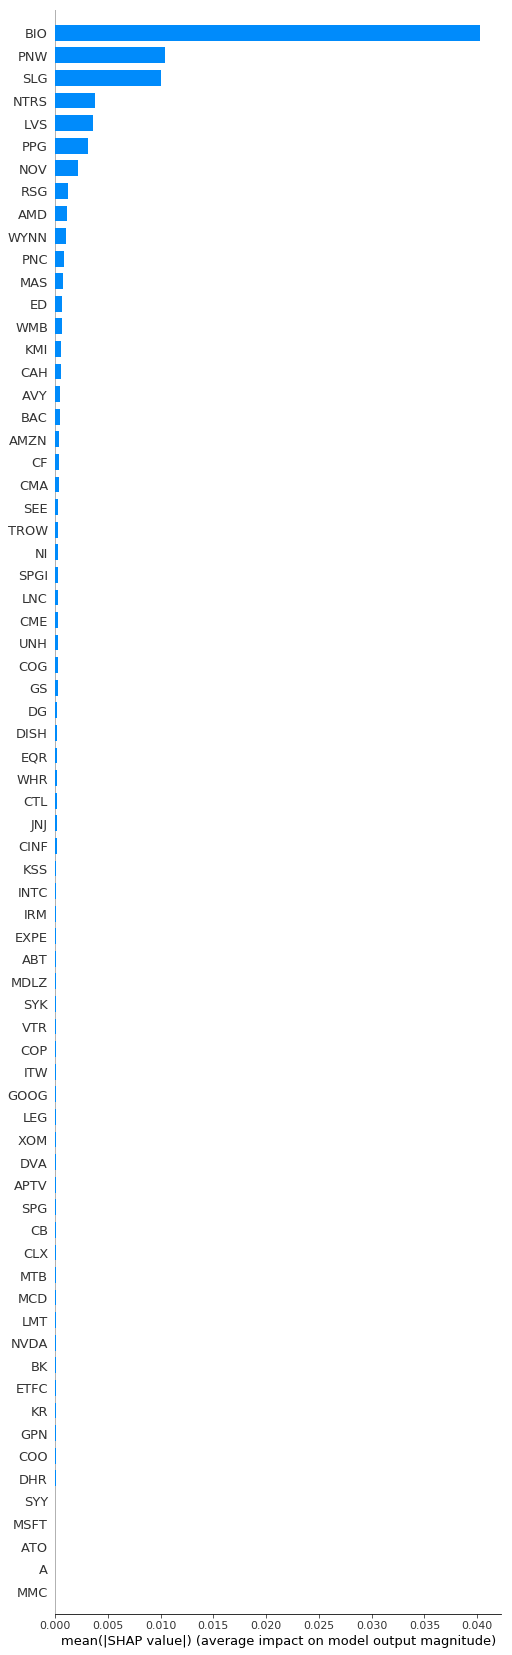

In [25]:
j=4

feature_cols =  df_data.drop(columns=["csi1"]).columns

plot_output = shap.summary_plot(shap_values_XGB_test, X_test, plot_type="bar", feature_names=feature_cols, max_display=70)

In [26]:
feature_imp = pd.DataFrame(xgb_reg.feature_importances_, index=df_data.drop(columns=[ticker_of_interest]).columns, columns=["Feature_Importance"])
xgb_columns = feature_imp.sort_values(by=["Feature_Importance"], ascending=False).index.tolist()
print(xgb_columns)

['BIO', 'SLG', 'RSG', 'LVS', 'CF', 'NOV', 'AMD', 'COG', 'WYNN', 'NTRS', 'BK', 'KR', 'GS', 'CME', 'PNC', 'MSFT', 'HAL', 'BAC', 'WMB', 'ATO', 'HON', 'LNC', 'WHR', 'CPB', 'KMB', 'CLX', 'SYY', 'KSS', 'PNW', 'XOM', 'CAH', 'LOW', 'ED', 'MDLZ', 'C', 'APTV', 'KMI', 'MAA', 'CMA', 'SEE', 'IRM', 'PBCT', 'STX', 'BXP', 'GE', 'SCHW', 'VTR', 'AWK', 'MMC', 'J', 'JCI', 'DFS', 'ESS', 'NTAP', 'WFC', 'AVB', 'AVY', 'ARE', 'EQR', 'EIX', 'DXC', 'CTL', 'BLK', 'JNJ', 'AON', 'DG', 'SYK', 'TMUS', 'NI', 'GPS', 'LHX', 'GD', 'MCD', 'COF', 'DISH', 'AKAM', 'MTB', 'JNPR', 'AES', 'K', 'WU', 'SBUX', 'TROW', 'LEG', 'LB', 'HPQ', 'NVDA', 'PWR', 'EXC', 'SPGI', 'INCY', 'NOC', 'EMR', 'CINF', 'FIS', 'NRG', 'ABT', 'EXR', 'DTE', 'BAX', 'ES', 'PLD', 'NEE', 'ECL', 'TYL', 'GPN', 'APH', 'PKI', 'RE', 'COO', 'DHR', 'PH', 'EW', 'ROK', 'INTC', 'MCK', 'BKNG', 'HST', 'MAR', 'DVA', 'CTSH', 'UNP', 'CB', 'SBAC', 'CAG', 'NFLX', 'AME', 'FLIR', 'WY', 'UNH', 'CCL', 'ETFC', 'ROP', 'MAS', 'EXPD', 'PPG', 'ITW', 'COP', 'WBA', 'TFC', 'LMT', 'HRL', 'S

## F_regression for Feature Selection

In [27]:
F_vals, P_vals = f_regression(X=df_data.drop(columns=[ticker_of_interest]).fillna(0).values, 
                              y=df_data[ticker_of_interest].values)

p_vals_df = pd.DataFrame(P_vals, index=df_data.drop(columns=[ticker_of_interest]).columns, columns=["P_values"])
p_vals_df = p_vals_df.sort_values(by=["P_values"])
p_vals_df

,P_values
WMB,0.000000
AMAT,0.000000
D,0.000000
LRCX,0.000000
PGR,0.000000
...,...
SEE,0.624557
EXPD,0.707750
PBCT,0.818485
HBAN,0.850069


# Experiments with Different Tickers Selection Methods and Sizes

## 1. 5 Tickers

### 1.1 Random Tickers

In [28]:
def try_model_on_selected_tickers(df_data, tickers, date):
    df_subset = filter_data(df_data, tickers, date)

    # "Difference" the data (statistics term)
    n_obs = 5 ## Beyond 5 results detriorate for majority of predictions

    # Isolate usable columns and ensure csi1 and csi_difference are in the final list
    final_cols = df_subset.columns 
    # Create training and test data
    X_train, X_test = df_subset[final_cols][0:-n_obs], df_subset[final_cols][-n_obs:]
    X_train_transformed = X_train.diff().dropna()

    # Train model and return predictions and coefficients
    pred, df_coef, lag_order, res = train_model(X_train_transformed, 
                                                X_test,
                                                n_obs, 
                                                verbose = True,
                                                maxlags=15,
                                                trend="ctt",
                                                ic="aic")
    
    output, MSE = make_predictions(X_train, pred, X_test)
    
    print("MSE : %.5f"%MSE)
    print("Lag Order : %d"%lag_order)
    
    return output, res

In [29]:
## If cell with random tickers fails then please run it few times because it selects repeating tickers sometimes.

selected_tickers = [ticker_of_interest] + random.choices(total_snp_tickers, k=5) + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BA', 'PKI', 'CHRW', 'SHW', 'EQR', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.91%
3,2019-12-30,0.43,0.43,99.16%
2,2019-12-27,0.43,0.43,99.28%
1,2019-12-26,0.43,0.43,99.32%
0,2019-12-24,0.43,0.43,99.78%


In [30]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BA,L1.PKI,L1.CHRW,L1.SHW,L1.EQR,L1.csi1
JPM,0.000271,0.000001,7.906140e-10,0.029821,0.006537,0.031715,0.022485,0.005546,0.028291,0.000486


### 1.2 Tickers with Low StdErr

In [31]:
selected_tickers = [ticker_of_interest] + std_err_df.index[:5].tolist() + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BKNG', 'AMZN', 'CMG', 'AZO', 'REGN', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.95%
3,2019-12-30,0.43,0.43,99.20%
2,2019-12-27,0.43,0.43,99.33%
1,2019-12-26,0.43,0.43,99.36%
0,2019-12-24,0.43,0.43,99.81%


In [32]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BKNG,L1.AMZN,L1.CMG,L1.AZO,L1.REGN,L1.csi1
JPM,0.000271,0.000001,7.884676e-10,0.029675,0.001013,0.001511,0.002169,0.002183,0.002729,0.000478


### 1.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [33]:
selected_tickers = [ticker_of_interest] + csi1_x_columns[:5]  + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.91%
3,2019-12-30,0.43,0.43,99.16%
2,2019-12-27,0.43,0.43,99.29%
1,2019-12-26,0.43,0.43,99.32%
0,2019-12-24,0.43,0.43,99.78%


In [34]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WELL,L1.ARE,L1.CLX,L1.TTWO,L1.CHD,L1.csi1
JPM,0.000271,0.000001,7.895583e-10,0.030805,0.030708,0.02327,0.019462,0.014847,0.046512,0.000502


### 1.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [35]:
selected_tickers = [ticker_of_interest] + csi1_y_columns[:5] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.93%
3,2019-12-30,0.43,0.43,99.18%
2,2019-12-27,0.43,0.43,99.31%
1,2019-12-26,0.43,0.43,99.35%
0,2019-12-24,0.43,0.43,99.82%


In [36]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.JNJ,L1.AME,L1.EBAY,L1.CAT,L1.MSFT,L1.csi1
JPM,0.000269,0.000001,7.837385e-10,0.029487,0.020703,0.043444,0.047424,0.016842,0.030288,0.000484


### 1.5 XGB Feature Importance Tickers

In [37]:
selected_tickers = [ticker_of_interest] + xgb_columns[:5]  + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BIO', 'SLG', 'RSG', 'LVS', 'CF', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.88%
3,2019-12-30,0.43,0.43,99.13%
2,2019-12-27,0.43,0.43,99.26%
1,2019-12-26,0.43,0.43,99.30%
0,2019-12-24,0.43,0.43,99.76%


In [38]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BIO,L1.SLG,L1.RSG,L1.LVS,L1.CF,L1.csi1
JPM,0.000271,0.000001,7.878772e-10,0.028898,0.007123,0.018756,0.045636,0.0236,0.023744,0.000482


### 1.6 Sklearn F_regression P-Values

In [39]:
selected_tickers = [ticker_of_interest] + p_vals_df.index.tolist()[:5] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WMB', 'AMAT', 'D', 'LRCX', 'PGR', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.91%
3,2019-12-30,0.43,0.43,99.16%
2,2019-12-27,0.43,0.43,99.29%
1,2019-12-26,0.43,0.43,99.32%
0,2019-12-24,0.43,0.43,99.78%


In [40]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WMB,L1.AMAT,L1.D,L1.LRCX,L1.PGR,L1.csi1
JPM,0.000271,0.000001,7.906138e-10,0.030081,0.026235,0.057076,0.029168,0.014456,0.043202,0.0005


## 2. 10 Tickers

### 2.1 Random Tickers

In [41]:
selected_tickers = [ticker_of_interest] + random.choices(total_snp_tickers, k=10) + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WLTW', 'CMG', 'NTRS', 'MOS', 'MCD', 'CMA', 'PVH', 'DISH', 'HUM', 'MTD', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.87%
3,2019-12-30,0.43,0.43,99.12%
2,2019-12-27,0.43,0.43,99.25%
1,2019-12-26,0.43,0.43,99.29%
0,2019-12-24,0.43,0.43,99.76%


In [42]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WLTW,L1.CMG,L1.NTRS,L1.MOS,L1.MCD,L1.CMA,L1.PVH,L1.DISH,L1.HUM,L1.MTD,L1.csi1
JPM,0.000272,0.000001,7.892608e-10,0.03874,0.015383,0.002177,0.031343,0.037667,0.015468,0.036212,0.011731,0.026268,0.006191,0.004187,0.000482


### 2.2 Tickers with Low StdErr

In [43]:
selected_tickers = [ticker_of_interest] + std_err_df.index[:10].tolist() + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BKNG', 'AMZN', 'CMG', 'AZO', 'REGN', 'BIIB', 'MTD', 'ABMD', 'ULTA', 'ILMN', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.97%
3,2019-12-30,0.43,0.43,99.22%
2,2019-12-27,0.43,0.43,99.34%
1,2019-12-26,0.43,0.43,99.37%
0,2019-12-24,0.43,0.43,99.83%


In [44]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BKNG,L1.AMZN,L1.CMG,L1.AZO,L1.REGN,L1.BIIB,L1.MTD,L1.ABMD,L1.ULTA,L1.ILMN,L1.csi1
JPM,0.000271,0.000001,7.899405e-10,0.029902,0.001014,0.001542,0.002175,0.002215,0.002923,0.003376,0.004285,0.004438,0.004742,0.00511,0.000481


### 2.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [45]:
selected_tickers = [ticker_of_interest] + csi1_x_columns[:10] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.82%
3,2019-12-30,0.43,0.43,99.07%
2,2019-12-27,0.43,0.43,99.20%
1,2019-12-26,0.43,0.43,99.23%
0,2019-12-24,0.43,0.43,99.69%


In [46]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WELL,L1.ARE,L1.CLX,L1.TTWO,L1.CHD,L1.LNC,L1.RE,L1.VRSN,L1.O,L1.EXR,L1.csi1
JPM,0.000271,0.000001,7.888120e-10,0.036234,0.033823,0.02468,0.019826,0.01513,0.04663,0.036988,0.009285,0.017001,0.046049,0.025067,0.000515


### 2.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [47]:
selected_tickers = [ticker_of_interest] + csi1_y_columns[:10] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.80%
3,2019-12-30,0.43,0.43,99.05%
2,2019-12-27,0.43,0.43,99.18%
1,2019-12-26,0.43,0.43,99.22%
0,2019-12-24,0.43,0.43,99.67%


In [48]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.JNJ,L1.AME,L1.EBAY,L1.CAT,L1.MSFT,L1.DVA,L1.PPG,L1.AJG,L1.MXIM,L1.CNC,L1.csi1
JPM,0.000268,9.979712e-07,7.798752e-10,0.02961,0.020815,0.043733,0.04719,0.017093,0.030681,0.023488,0.020583,0.047956,0.034335,0.02793,0.000486


### 2.5 XGB Feature Importance Tickers

In [49]:
selected_tickers = [ticker_of_interest] + xgb_columns[:10] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BIO', 'SLG', 'RSG', 'LVS', 'CF', 'NOV', 'AMD', 'COG', 'WYNN', 'NTRS', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.82%
3,2019-12-30,0.43,0.43,99.07%
2,2019-12-27,0.43,0.43,99.20%
1,2019-12-26,0.43,0.43,99.24%
0,2019-12-24,0.43,0.43,99.72%


In [50]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BIO,L1.SLG,L1.RSG,L1.LVS,L1.CF,L1.NOV,L1.AMD,L1.COG,L1.WYNN,L1.NTRS,L1.csi1
JPM,0.000272,0.000001,7.891718e-10,0.034509,0.007138,0.018841,0.046228,0.031339,0.024183,0.029611,0.046322,0.045633,0.010289,0.029414,0.000488


### 2.6 Sklearn F_regression P-Values

In [51]:
selected_tickers = [ticker_of_interest] + p_vals_df.index.tolist()[:10] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WMB', 'AMAT', 'D', 'LRCX', 'PGR', 'WM', 'OMC', 'SCHW', 'BIO', 'LHX', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.94%
3,2019-12-30,0.43,0.43,99.20%
2,2019-12-27,0.43,0.43,99.32%
1,2019-12-26,0.43,0.43,99.36%
0,2019-12-24,0.43,0.43,99.82%


In [52]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WMB,L1.AMAT,L1.D,L1.LRCX,L1.PGR,L1.WM,L1.OMC,L1.SCHW,L1.BIO,L1.LHX,L1.csi1
JPM,0.000272,0.000001,7.918812e-10,0.034618,0.026347,0.057256,0.031494,0.01452,0.044093,0.037697,0.028404,0.051687,0.007147,0.013644,0.000507


## 3. 20 Tickers

### 3.1 Random Tickers

In [53]:
selected_tickers = [ticker_of_interest] + random.choices(total_snp_tickers, k=20) + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'FBHS', 'ABBV', 'PKG', 'LEG', 'SBUX', 'VFC', 'RCL', 'IBM', 'UNH', 'TMO', 'BAX', 'SNPS', 'KMI', 'DVN', 'STZ', 'SLB', 'CVX', 'DRI', 'GS', 'AJG', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.88%
3,2019-12-30,0.43,0.43,99.13%
2,2019-12-27,0.43,0.43,99.26%
1,2019-12-26,0.43,0.43,99.30%
0,2019-12-24,0.43,0.43,99.74%


In [54]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.FBHS,L1.ABBV,L1.PKG,L1.LEG,L1.SBUX,L1.VFC,L1.RCL,L1.IBM,L1.UNH,L1.TMO,L1.BAX,L1.SNPS,L1.KMI,L1.DVN,L1.STZ,L1.SLB,L1.CVX,L1.DRI,L1.GS,L1.AJG,L1.csi1
JPM,0.000272,0.000001,7.895260e-10,0.037644,0.036153,0.018589,0.019226,0.045256,0.034338,0.024299,0.014253,0.014623,0.010789,0.012796,0.039302,0.028483,0.066118,0.032129,0.009928,0.03095,0.022445,0.019732,0.013269,0.048339,0.000484


### 3.2 Tickers with Low StdErr

In [55]:
selected_tickers = [ticker_of_interest] + std_err_df.index[:20].tolist() + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BKNG', 'AMZN', 'CMG', 'AZO', 'REGN', 'BIIB', 'MTD', 'ABMD', 'ULTA', 'ILMN', 'CHTR', 'EQIX', 'ISRG', 'TDG', 'ANET', 'NFLX', 'ALGN', 'SHW', 'ORLY', 'GWW', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.97%
3,2019-12-30,0.43,0.43,99.22%
2,2019-12-27,0.43,0.43,99.34%
1,2019-12-26,0.43,0.43,99.37%
0,2019-12-24,0.43,0.43,99.82%


In [56]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BKNG,L1.AMZN,L1.CMG,L1.AZO,L1.REGN,L1.BIIB,L1.MTD,L1.ABMD,L1.ULTA,L1.ILMN,L1.CHTR,L1.EQIX,L1.ISRG,L1.TDG,L1.ANET,L1.NFLX,L1.ALGN,L1.SHW,L1.ORLY,L1.GWW,L1.csi1
JPM,0.000271,0.000001,7.889033e-10,0.031303,0.001021,0.00165,0.002196,0.002877,0.002921,0.003381,0.004394,0.004764,0.004788,0.005191,0.005071,0.00474,0.005409,0.005333,0.005478,0.005495,0.00591,0.00564,0.007417,0.00603,0.000488


### 3.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [57]:
selected_tickers = [ticker_of_interest] + csi1_x_columns[:20] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.89%
3,2019-12-30,0.43,0.43,99.14%
2,2019-12-27,0.43,0.43,99.26%
1,2019-12-26,0.43,0.43,99.29%
0,2019-12-24,0.43,0.43,99.75%


In [58]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WELL,L1.ARE,L1.CLX,L1.TTWO,L1.CHD,L1.LNC,L1.RE,L1.VRSN,L1.O,L1.EXR,L1.K,L1.FE,L1.FLIR,L1.PLD,L1.FIS,L1.AVB,L1.ADSK,L1.HAL,L1.OXY,L1.ATVI,L1.csi1
JPM,0.000272,0.000001,7.888172e-10,0.036839,0.036002,0.026111,0.020515,0.0177,0.046823,0.037451,0.009427,0.017389,0.047953,0.026364,0.03115,0.056043,0.042449,0.048831,0.026469,0.018456,0.013575,0.038152,0.028041,0.0311,0.000522


### 3.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [59]:
selected_tickers = [ticker_of_interest] + csi1_y_columns[:20] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.78%
3,2019-12-30,0.43,0.43,99.04%
2,2019-12-27,0.43,0.43,99.16%
1,2019-12-26,0.43,0.43,99.20%
0,2019-12-24,0.43,0.43,99.65%


In [60]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.JNJ,L1.AME,L1.EBAY,L1.CAT,L1.MSFT,L1.DVA,L1.PPG,L1.AJG,L1.MXIM,L1.CNC,L1.IT,L1.SEE,L1.DLR,L1.EQIX,L1.GWW,L1.PH,L1.ITW,L1.VAR,L1.FCX,L1.MHK,L1.csi1
JPM,0.000268,9.974489e-07,7.790163e-10,0.030776,0.021027,0.045873,0.047747,0.019774,0.030908,0.023529,0.021562,0.048391,0.034514,0.028191,0.0156,0.037319,0.020477,0.005495,0.006181,0.018464,0.02367,0.019091,0.0565,0.008468,0.000493


### 3.5 XGB Feature Importance Tickers

In [61]:
selected_tickers = [ticker_of_interest] + xgb_columns[:20] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BIO', 'SLG', 'RSG', 'LVS', 'CF', 'NOV', 'AMD', 'COG', 'WYNN', 'NTRS', 'BK', 'KR', 'GS', 'CME', 'PNC', 'MSFT', 'HAL', 'BAC', 'WMB', 'ATO', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.80%
3,2019-12-30,0.43,0.43,99.05%
2,2019-12-27,0.43,0.43,99.18%
1,2019-12-26,0.43,0.43,99.22%
0,2019-12-24,0.43,0.43,99.69%


In [62]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BIO,L1.SLG,L1.RSG,L1.LVS,L1.CF,L1.NOV,L1.AMD,L1.COG,L1.WYNN,L1.NTRS,L1.BK,L1.KR,L1.GS,L1.CME,L1.PNC,L1.MSFT,L1.HAL,L1.BAC,L1.WMB,L1.ATO,L1.csi1
JPM,0.000273,0.000001,7.926317e-10,0.051812,0.007175,0.019367,0.051639,0.031588,0.024733,0.034804,0.046881,0.047135,0.010372,0.035408,0.063585,0.042178,0.014126,0.01564,0.029812,0.031609,0.040253,0.157278,0.028043,0.031473,0.000508


### 3.6 Sklearn F_regression P-Values

In [63]:
selected_tickers = [ticker_of_interest] + p_vals_df.index.tolist()[:20] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WMB', 'AMAT', 'D', 'LRCX', 'PGR', 'WM', 'OMC', 'SCHW', 'BIO', 'LHX', 'TTWO', 'RSG', 'DXC', 'SPG', 'LW', 'ADBE', 'IR', 'MSFT', 'FTV', 'LB', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.89%
3,2019-12-30,0.43,0.43,99.14%
2,2019-12-27,0.43,0.43,99.27%
1,2019-12-26,0.43,0.43,99.31%
0,2019-12-24,0.43,0.43,99.76%


In [64]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WMB,L1.AMAT,L1.D,L1.LRCX,L1.PGR,L1.WM,L1.OMC,L1.SCHW,L1.BIO,L1.LHX,L1.TTWO,L1.RSG,L1.DXC,L1.SPG,L1.ADBE,L1.MSFT,L1.LB,L1.csi1
JPM,0.000272,0.000001,7.939805e-10,0.036284,0.026564,0.057783,0.033553,0.014617,0.044485,0.053199,0.028991,0.052071,0.007214,0.013829,0.015854,0.069963,0.022123,0.011866,0.011942,0.034585,0.018875,0.000513


## 4. 30 Tickers

### 4.1 Random Tickers

In [70]:
selected_tickers = [ticker_of_interest] + random.choices(total_snp_tickers, k=30) + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'IRM', 'ANTM', 'ROK', 'MRO', 'WLTW', 'WST', 'AEE', 'UA', 'TXN', 'WAT', 'GPC', 'PRU', 'PNC', 'APD', 'EXR', 'EIX', 'STZ', 'DG', 'WRK', 'CVS', 'MOS', 'EL', 'ZTS', 'YUM', 'LKQ', 'STT', 'MKTX', 'PKI', 'IQV', 'CDW', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.77%
3,2019-12-30,0.43,0.43,99.03%
2,2019-12-27,0.43,0.43,99.16%
1,2019-12-26,0.43,0.43,99.20%
0,2019-12-24,0.43,0.43,99.70%


In [71]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.IRM,L1.ANTM,L1.ROK,L1.MRO,L1.WLTW,L1.WST,L1.AEE,L1.TXN,L1.WAT,L1.GPC,L1.PRU,L1.PNC,L1.APD,L1.EXR,L1.EIX,L1.STZ,L1.DG,L1.CVS,L1.MOS,L1.EL,L1.ZTS,L1.YUM,L1.LKQ,L1.STT,L1.MKTX,L1.PKI,L1.IQV,L1.CDW,L1.csi1
JPM,0.000271,0.000001,7.888229e-10,0.043691,0.05304,0.008507,0.014014,0.054212,0.015651,0.020678,0.048168,0.023088,0.011548,0.024878,0.028054,0.029301,0.01659,0.023191,0.027004,0.010041,0.016987,0.021603,0.039642,0.015182,0.029331,0.026346,0.054711,0.029222,0.007017,0.035393,0.021247,0.026816,0.000512


### 4.2 Tickers with Low StdErr

In [72]:
selected_tickers = [ticker_of_interest] + std_err_df.index[:30].tolist() + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BKNG', 'AMZN', 'CMG', 'AZO', 'REGN', 'BIIB', 'MTD', 'ABMD', 'ULTA', 'ILMN', 'CHTR', 'EQIX', 'ISRG', 'TDG', 'ANET', 'NFLX', 'ALGN', 'SHW', 'ORLY', 'GWW', 'HUM', 'BLK', 'BA', 'AVGO', 'MKTX', 'IPGP', 'BIO', 'DPZ', 'MLM', 'ALXN', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.87%
3,2019-12-30,0.43,0.43,99.12%
2,2019-12-27,0.43,0.43,99.25%
1,2019-12-26,0.43,0.43,99.28%
0,2019-12-24,0.43,0.43,99.74%


In [73]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BKNG,L1.AMZN,L1.CMG,L1.AZO,L1.REGN,L1.BIIB,L1.MTD,L1.ABMD,L1.ULTA,L1.ILMN,L1.CHTR,L1.EQIX,L1.ISRG,L1.TDG,L1.ANET,L1.NFLX,L1.ALGN,L1.SHW,L1.ORLY,L1.GWW,L1.HUM,L1.BLK,L1.BA,L1.AVGO,L1.MKTX,L1.IPGP,L1.BIO,L1.DPZ,L1.MLM,L1.ALXN,L1.csi1
JPM,0.000272,0.000001,7.928186e-10,0.03293,0.001029,0.001667,0.002229,0.002894,0.003054,0.003451,0.004423,0.004813,0.004814,0.005301,0.00513,0.004861,0.005472,0.005374,0.005617,0.005533,0.005973,0.005763,0.007499,0.006157,0.006334,0.006532,0.006663,0.006705,0.006871,0.00755,0.007356,0.007474,0.007553,0.008238,0.000499


### 4.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [74]:
selected_tickers = [ticker_of_interest] + csi1_x_columns[:30] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,99.01%
3,2019-12-30,0.43,0.43,99.26%
2,2019-12-27,0.43,0.43,99.38%
1,2019-12-26,0.43,0.43,99.41%
0,2019-12-24,0.43,0.43,99.86%


In [75]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WELL,L1.ARE,L1.CLX,L1.TTWO,L1.CHD,L1.LNC,L1.RE,L1.VRSN,L1.O,L1.EXR,L1.K,L1.FE,L1.FLIR,L1.PLD,L1.FIS,L1.AVB,L1.ADSK,L1.HAL,L1.OXY,L1.ATVI,L1.TYL,L1.ESS,L1.HES,L1.AAPL,L1.CAH,L1.PSA,L1.WST,L1.TDY,L1.APA,L1.MDT,L1.csi1
JPM,0.000272,0.000001,7.901877e-10,0.037496,0.036306,0.026303,0.020645,0.017787,0.047218,0.038541,0.009444,0.01779,0.048475,0.036697,0.031602,0.056988,0.042951,0.049438,0.026756,0.024177,0.013672,0.042335,0.031668,0.031527,0.009977,0.015431,0.026883,0.013545,0.021826,0.014762,0.020705,0.013051,0.028172,0.029034,0.00053


### 4.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [76]:
selected_tickers = [ticker_of_interest] + csi1_y_columns[:30] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK', 'TIF', 'SYK', 'CNP', 'URI', 'SWK', 'AMD', 'CDNS', 'DPZ', 'TXT', 'AMZN', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.61%
3,2019-12-30,0.43,0.43,98.87%
2,2019-12-27,0.43,0.43,99.00%
1,2019-12-26,0.43,0.43,99.04%
0,2019-12-24,0.43,0.43,99.52%


In [77]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.JNJ,L1.AME,L1.EBAY,L1.CAT,L1.MSFT,L1.DVA,L1.PPG,L1.AJG,L1.MXIM,L1.CNC,L1.IT,L1.SEE,L1.DLR,L1.EQIX,L1.GWW,L1.PH,L1.ITW,L1.VAR,L1.FCX,L1.MHK,L1.TIF,L1.SYK,L1.CNP,L1.URI,L1.SWK,L1.AMD,L1.CDNS,L1.DPZ,L1.TXT,L1.AMZN,L1.csi1
JPM,0.000267,9.970628e-07,7.794475e-10,0.032121,0.021922,0.046436,0.048411,0.020253,0.033112,0.023588,0.021658,0.04954,0.035395,0.028396,0.015648,0.037728,0.021095,0.005514,0.006267,0.018799,0.02448,0.019569,0.057013,0.008641,0.013939,0.017242,0.086968,0.012062,0.018133,0.047952,0.049397,0.007368,0.040684,0.001688,0.000506


### 4.5 XGB Feature Importance Tickers

In [78]:
selected_tickers = [ticker_of_interest] + xgb_columns[:30] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BIO', 'SLG', 'RSG', 'LVS', 'CF', 'NOV', 'AMD', 'COG', 'WYNN', 'NTRS', 'BK', 'KR', 'GS', 'CME', 'PNC', 'MSFT', 'HAL', 'BAC', 'WMB', 'ATO', 'HON', 'LNC', 'WHR', 'CPB', 'KMB', 'CLX', 'SYY', 'KSS', 'PNW', 'XOM', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.83%
3,2019-12-30,0.43,0.43,99.09%
2,2019-12-27,0.43,0.43,99.21%
1,2019-12-26,0.43,0.43,99.25%
0,2019-12-24,0.43,0.43,99.72%


In [79]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BIO,L1.SLG,L1.RSG,L1.LVS,L1.CF,L1.NOV,L1.AMD,L1.COG,L1.WYNN,L1.NTRS,L1.BK,L1.KR,L1.GS,L1.CME,L1.PNC,L1.MSFT,L1.HAL,L1.BAC,L1.WMB,L1.ATO,L1.HON,L1.LNC,L1.WHR,L1.CPB,L1.KMB,L1.CLX,L1.SYY,L1.KSS,L1.PNW,L1.XOM,L1.csi1
JPM,0.000274,0.000001,7.950464e-10,0.052227,0.007197,0.019542,0.05311,0.031582,0.024725,0.03505,0.046974,0.04755,0.010364,0.035859,0.063917,0.043496,0.014271,0.015723,0.030468,0.032959,0.041785,0.15961,0.028229,0.04188,0.025428,0.040503,0.008701,0.036258,0.023511,0.020839,0.03955,0.017882,0.043595,0.031778,0.000525


### 4.6 Sklearn F_regression P-Values

In [80]:
selected_tickers = [ticker_of_interest] + p_vals_df.index.tolist()[:30] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WMB', 'AMAT', 'D', 'LRCX', 'PGR', 'WM', 'OMC', 'SCHW', 'BIO', 'LHX', 'TTWO', 'RSG', 'DXC', 'SPG', 'LW', 'ADBE', 'IR', 'MSFT', 'FTV', 'LB', 'NVDA', 'FRT', 'BXP', 'SYK', 'EQR', 'GPN', 'DISH', 'ADSK', 'NOV', 'BA', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.83%
3,2019-12-30,0.43,0.43,99.08%
2,2019-12-27,0.43,0.43,99.21%
1,2019-12-26,0.43,0.43,99.25%
0,2019-12-24,0.43,0.43,99.71%


In [81]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WMB,L1.AMAT,L1.D,L1.LRCX,L1.PGR,L1.WM,L1.OMC,L1.SCHW,L1.BIO,L1.LHX,L1.TTWO,L1.RSG,L1.DXC,L1.SPG,L1.ADBE,L1.MSFT,L1.LB,L1.NVDA,L1.FRT,L1.BXP,L1.SYK,L1.EQR,L1.GPN,L1.DISH,L1.ADSK,L1.NOV,L1.BA,L1.csi1
JPM,0.000273,0.000001,7.982315e-10,0.037082,0.027237,0.05909,0.034558,0.014689,0.044847,0.053518,0.029146,0.05248,0.007291,0.014056,0.016076,0.070633,0.022295,0.0163,0.012764,0.034893,0.018993,0.008177,0.025677,0.023797,0.016934,0.036213,0.021073,0.026523,0.014541,0.029755,0.006674,0.000522


## 5. 40 Tickers

### 5.1 Random Tickers

In [82]:
selected_tickers = [ticker_of_interest] + random.choices(total_snp_tickers, k=40) + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'RMD', 'APA', 'EXC', 'DTE', 'HCA', 'PKG', 'FMC', 'COTY', 'TXN', 'ACN', 'ETN', 'EQR', 'MO', 'VIAC', 'EIX', 'CRM', 'DGX', 'NEE', 'LLY', 'PCAR', 'MSFT', 'CHD', 'REGN', 'LIN', 'COF', 'WHR', 'PKI', 'SEE', 'VAR', 'ALB', 'IR', 'COG', 'DVN', 'CMG', 'VZ', 'CINF', 'JBHT', 'SBUX', 'IFF', 'KMI', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.79%
3,2019-12-30,0.43,0.43,99.05%
2,2019-12-27,0.43,0.43,99.17%
1,2019-12-26,0.43,0.43,99.21%
0,2019-12-24,0.43,0.43,99.68%


In [83]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.RMD,L1.APA,L1.EXC,L1.DTE,L1.HCA,L1.PKG,L1.FMC,L1.COTY,L1.TXN,L1.ACN,L1.ETN,L1.EQR,L1.MO,L1.EIX,L1.CRM,L1.DGX,L1.NEE,L1.LLY,L1.PCAR,L1.MSFT,L1.CHD,L1.REGN,L1.LIN,L1.COF,L1.WHR,L1.PKI,L1.SEE,L1.VAR,L1.ALB,L1.COG,L1.DVN,L1.CMG,L1.VZ,L1.CINF,L1.JBHT,L1.SBUX,L1.IFF,L1.KMI,L1.csi1
JPM,0.000273,0.000001,7.921058e-10,0.036282,0.017942,0.027767,0.068524,0.039756,0.016895,0.020328,0.030184,0.045039,0.022952,0.020272,0.036682,0.031748,0.035888,0.028573,0.016643,0.024762,0.024974,0.020453,0.03495,0.034145,0.040652,0.002929,0.017385,0.025731,0.008775,0.033836,0.038926,0.019897,0.017183,0.050147,0.035087,0.002232,0.047415,0.035519,0.020567,0.035557,0.014024,0.067699,0.000521


### 5.2 Tickers with Low StdErr

In [84]:
selected_tickers = [ticker_of_interest] + std_err_df.index[:40].tolist() + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BKNG', 'AMZN', 'CMG', 'AZO', 'REGN', 'BIIB', 'MTD', 'ABMD', 'ULTA', 'ILMN', 'CHTR', 'EQIX', 'ISRG', 'TDG', 'ANET', 'NFLX', 'ALGN', 'SHW', 'ORLY', 'GWW', 'HUM', 'BLK', 'BA', 'AVGO', 'MKTX', 'IPGP', 'BIO', 'DPZ', 'MLM', 'ALXN', 'WYNN', 'PXD', 'NOC', 'NVDA', 'AAP', 'MCK', 'TFX', 'SIVB', 'DXCM', 'COO', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.79%
3,2019-12-30,0.43,0.43,99.04%
2,2019-12-27,0.43,0.43,99.17%
1,2019-12-26,0.43,0.43,99.20%
0,2019-12-24,0.43,0.43,99.67%


In [85]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BKNG,L1.AMZN,L1.CMG,L1.AZO,L1.REGN,L1.BIIB,L1.MTD,L1.ABMD,L1.ULTA,L1.ILMN,L1.CHTR,L1.EQIX,L1.ISRG,L1.TDG,L1.ANET,L1.NFLX,L1.ALGN,L1.SHW,L1.ORLY,L1.GWW,L1.HUM,L1.BLK,L1.BA,L1.AVGO,L1.MKTX,L1.IPGP,L1.BIO,L1.DPZ,L1.MLM,L1.ALXN,L1.WYNN,L1.PXD,L1.NOC,L1.NVDA,L1.AAP,L1.MCK,L1.TFX,L1.SIVB,L1.DXCM,L1.COO,L1.csi1
JPM,0.000273,0.000001,7.927374e-10,0.036899,0.00103,0.001711,0.002232,0.002971,0.003091,0.003458,0.004544,0.004921,0.004844,0.005322,0.00515,0.004923,0.005616,0.00548,0.005698,0.005571,0.006007,0.005782,0.007768,0.006181,0.006396,0.00662,0.006758,0.006837,0.006984,0.007645,0.007408,0.00749,0.007615,0.008223,0.007826,0.007514,0.008295,0.008121,0.009447,0.008405,0.008883,0.00792,0.009004,0.008784,0.000507


### 5.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [86]:
selected_tickers = [ticker_of_interest] + csi1_x_columns[:40] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'RJF', 'USB', 'PEP', 'BXP', 'NBL', 'EQR', 'MAA', 'VLO', 'WY', 'PWR', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,99.00%
3,2019-12-30,0.43,0.43,99.25%
2,2019-12-27,0.43,0.43,99.37%
1,2019-12-26,0.43,0.43,99.40%
0,2019-12-24,0.43,0.43,99.84%


In [87]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WELL,L1.ARE,L1.CLX,L1.TTWO,L1.CHD,L1.LNC,L1.RE,L1.VRSN,L1.O,L1.EXR,L1.K,L1.FE,L1.FLIR,L1.PLD,L1.FIS,L1.AVB,L1.ADSK,L1.HAL,L1.OXY,L1.ATVI,L1.TYL,L1.ESS,L1.HES,L1.AAPL,L1.CAH,L1.PSA,L1.WST,L1.TDY,L1.APA,L1.MDT,L1.RJF,L1.USB,L1.PEP,L1.BXP,L1.NBL,L1.EQR,L1.MAA,L1.VLO,L1.WY,L1.PWR,L1.csi1
JPM,0.000272,0.000001,7.897520e-10,0.042776,0.036889,0.027442,0.021021,0.017793,0.048033,0.042126,0.009521,0.01788,0.049643,0.036972,0.032459,0.057595,0.043179,0.050783,0.026801,0.026799,0.013805,0.043299,0.032032,0.031736,0.010049,0.016199,0.02803,0.013669,0.022023,0.014987,0.020788,0.013176,0.029419,0.029399,0.035523,0.079862,0.03139,0.025256,0.044307,0.047594,0.033029,0.01931,0.066522,0.047459,0.000536


### 5.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [88]:
selected_tickers = [ticker_of_interest] + csi1_y_columns[:40] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK', 'TIF', 'SYK', 'CNP', 'URI', 'SWK', 'AMD', 'CDNS', 'DPZ', 'TXT', 'AMZN', 'YUM', 'NUE', 'IP', 'PWR', 'LHX', 'PHM', 'RL', 'CLX', 'PKG', 'RE', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.57%
3,2019-12-30,0.43,0.43,98.82%
2,2019-12-27,0.43,0.43,98.95%
1,2019-12-26,0.43,0.43,98.99%
0,2019-12-24,0.43,0.43,99.47%


In [89]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.JNJ,L1.AME,L1.EBAY,L1.CAT,L1.MSFT,L1.DVA,L1.PPG,L1.AJG,L1.MXIM,L1.CNC,L1.IT,L1.SEE,L1.DLR,L1.EQIX,L1.GWW,L1.PH,L1.ITW,L1.VAR,L1.FCX,L1.MHK,L1.TIF,L1.SYK,L1.CNP,L1.URI,L1.SWK,L1.AMD,L1.CDNS,L1.DPZ,L1.TXT,L1.AMZN,L1.YUM,L1.NUE,L1.IP,L1.PWR,L1.LHX,L1.PHM,L1.RL,L1.CLX,L1.PKG,L1.RE,L1.csi1
JPM,0.000268,0.000001,7.817736e-10,0.032814,0.022168,0.046812,0.048582,0.020432,0.033345,0.023683,0.02204,0.050922,0.035577,0.028777,0.015686,0.038896,0.021331,0.005623,0.006347,0.01897,0.024708,0.019603,0.059819,0.008831,0.014281,0.017334,0.088482,0.012322,0.018222,0.04817,0.049794,0.007498,0.04138,0.00172,0.02637,0.031615,0.04952,0.048469,0.013831,0.061849,0.009576,0.016571,0.024893,0.009499,0.000512


### 5.5 XGB Feature Importance Tickers

In [90]:
selected_tickers = [ticker_of_interest] + xgb_columns[:40] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BIO', 'SLG', 'RSG', 'LVS', 'CF', 'NOV', 'AMD', 'COG', 'WYNN', 'NTRS', 'BK', 'KR', 'GS', 'CME', 'PNC', 'MSFT', 'HAL', 'BAC', 'WMB', 'ATO', 'HON', 'LNC', 'WHR', 'CPB', 'KMB', 'CLX', 'SYY', 'KSS', 'PNW', 'XOM', 'CAH', 'LOW', 'ED', 'MDLZ', 'C', 'APTV', 'KMI', 'MAA', 'CMA', 'SEE', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.82%
3,2019-12-30,0.43,0.43,99.07%
2,2019-12-27,0.43,0.43,99.20%
1,2019-12-26,0.43,0.43,99.23%
0,2019-12-24,0.43,0.43,99.71%


In [91]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BIO,L1.SLG,L1.RSG,L1.LVS,L1.CF,L1.NOV,L1.AMD,L1.COG,L1.WYNN,L1.NTRS,L1.BK,L1.KR,L1.GS,L1.CME,L1.PNC,L1.MSFT,L1.HAL,L1.BAC,L1.WMB,L1.ATO,L1.HON,L1.LNC,L1.WHR,L1.CPB,L1.KMB,L1.CLX,L1.SYY,L1.KSS,L1.PNW,L1.XOM,L1.CAH,L1.LOW,L1.ED,L1.MDLZ,L1.C,L1.APTV,L1.KMI,L1.MAA,L1.CMA,L1.SEE,L1.csi1
JPM,0.000275,0.000001,7.977494e-10,0.054828,0.007225,0.021191,0.05377,0.031857,0.024888,0.035655,0.047161,0.048655,0.010414,0.036456,0.064462,0.04409,0.014453,0.01584,0.032598,0.033564,0.04237,0.168576,0.030527,0.043707,0.025719,0.041754,0.008771,0.037805,0.023799,0.020974,0.039772,0.018242,0.053987,0.032347,0.021954,0.021785,0.052798,0.050823,0.059487,0.022072,0.071065,0.025737,0.043342,0.038404,0.000531


### 5.6 Sklearn F_regression P-Values

In [92]:
selected_tickers = [ticker_of_interest] + p_vals_df.index.tolist()[:40] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WMB', 'AMAT', 'D', 'LRCX', 'PGR', 'WM', 'OMC', 'SCHW', 'BIO', 'LHX', 'TTWO', 'RSG', 'DXC', 'SPG', 'LW', 'ADBE', 'IR', 'MSFT', 'FTV', 'LB', 'NVDA', 'FRT', 'BXP', 'SYK', 'EQR', 'GPN', 'DISH', 'ADSK', 'NOV', 'BA', 'PRGO', 'TXN', 'MCHP', 'PYPL', 'VZ', 'GPC', 'TFX', 'ALGN', 'ANET', 'AVB', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.83%
3,2019-12-30,0.43,0.43,99.08%
2,2019-12-27,0.43,0.43,99.21%
1,2019-12-26,0.43,0.43,99.25%
0,2019-12-24,0.43,0.43,99.70%


In [93]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WMB,L1.AMAT,L1.D,L1.LRCX,L1.PGR,L1.WM,L1.OMC,L1.SCHW,L1.BIO,L1.LHX,L1.TTWO,L1.RSG,L1.DXC,L1.SPG,L1.ADBE,L1.MSFT,L1.LB,L1.NVDA,L1.FRT,L1.BXP,L1.SYK,L1.EQR,L1.GPN,L1.DISH,L1.ADSK,L1.NOV,L1.BA,L1.PRGO,L1.TXN,L1.MCHP,L1.VZ,L1.GPC,L1.TFX,L1.ALGN,L1.ANET,L1.AVB,L1.csi1
JPM,0.000274,0.000001,8.006693e-10,0.037638,0.027442,0.059803,0.035019,0.015098,0.045177,0.053966,0.02953,0.052857,0.007397,0.014139,0.016228,0.071232,0.022379,0.016473,0.013097,0.035165,0.019158,0.008503,0.025988,0.024803,0.017905,0.045637,0.021334,0.026671,0.01477,0.029885,0.006702,0.009269,0.029219,0.029146,0.047741,0.025594,0.008753,0.005718,0.005681,0.021845,0.000526


## 6. 50 Tickers

### 6.1 Random Tickers

In [103]:
selected_tickers = [ticker_of_interest] + random.choices(total_snp_tickers, k=50) + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'ETFC', 'AWK', 'LEG', 'GPS', 'NTRS', 'HLT', 'AEE', 'GPN', 'ES', 'KLAC', 'MRK', 'CCL', 'HII', 'IPG', 'AIZ', 'EIX', 'REGN', 'SEE', 'PG', 'LMT', 'BMY', 'SWKS', 'DE', 'APD', 'IQV', 'KSS', 'CTAS', 'DFS', 'FB', 'HES', 'VIAC', 'AZO', 'WM', 'HBAN', 'FISV', 'PH', 'NOW', 'EXPD', 'HSIC', 'WELL', 'ZTS', 'PRGO', 'SLB', 'EQIX', 'AMZN', 'GD', 'MSFT', 'MHK', 'RE', 'ITW', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.94%
3,2019-12-30,0.43,0.43,99.19%
2,2019-12-27,0.43,0.43,99.31%
1,2019-12-26,0.43,0.43,99.35%
0,2019-12-24,0.43,0.43,99.79%


In [104]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.ETFC,L1.AWK,L1.LEG,L1.GPS,L1.NTRS,L1.HLT,L1.AEE,L1.GPN,L1.ES,L1.KLAC,L1.MRK,L1.CCL,L1.HII,L1.IPG,L1.AIZ,L1.EIX,L1.REGN,L1.SEE,L1.PG,L1.LMT,L1.BMY,L1.SWKS,L1.DE,L1.APD,L1.IQV,L1.KSS,L1.CTAS,L1.DFS,L1.FB,L1.HES,L1.AZO,L1.WM,L1.HBAN,L1.FISV,L1.PH,L1.NOW,L1.EXPD,L1.HSIC,L1.WELL,L1.ZTS,L1.PRGO,L1.SLB,L1.EQIX,L1.AMZN,L1.GD,L1.MSFT,L1.MHK,L1.RE,L1.ITW,L1.csi1
JPM,0.000272,0.000001,7.933956e-10,0.041904,0.049841,0.041999,0.047932,0.041183,0.032642,0.031251,0.069904,0.021876,0.069136,0.016877,0.037247,0.033216,0.009772,0.079477,0.021835,0.02829,0.003008,0.03851,0.032735,0.010197,0.025635,0.015549,0.015638,0.016937,0.021441,0.019501,0.015588,0.039885,0.011647,0.023118,0.002268,0.041688,0.207506,0.040932,0.017918,0.009887,0.039257,0.03056,0.029292,0.029933,0.009293,0.030493,0.005132,0.001847,0.01705,0.035676,0.009364,0.009874,0.024249,0.000524


### 6.2 Tickers with Low StdErr

In [105]:
selected_tickers = [ticker_of_interest] + std_err_df.index[:50].tolist() + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BKNG', 'AMZN', 'CMG', 'AZO', 'REGN', 'BIIB', 'MTD', 'ABMD', 'ULTA', 'ILMN', 'CHTR', 'EQIX', 'ISRG', 'TDG', 'ANET', 'NFLX', 'ALGN', 'SHW', 'ORLY', 'GWW', 'HUM', 'BLK', 'BA', 'AVGO', 'MKTX', 'IPGP', 'BIO', 'DPZ', 'MLM', 'ALXN', 'WYNN', 'PXD', 'NOC', 'NVDA', 'AAP', 'MCK', 'TFX', 'SIVB', 'DXCM', 'COO', 'LMT', 'WHR', 'HII', 'ZBRA', 'INCY', 'MHK', 'FLT', 'VRTX', 'PRGO', 'ESS', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.87%
3,2019-12-30,0.43,0.43,99.12%
2,2019-12-27,0.43,0.43,99.25%
1,2019-12-26,0.43,0.43,99.28%
0,2019-12-24,0.43,0.43,99.77%


In [106]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BKNG,L1.AMZN,L1.CMG,L1.AZO,L1.REGN,L1.BIIB,L1.MTD,L1.ABMD,L1.ULTA,L1.ILMN,L1.CHTR,L1.EQIX,L1.ISRG,L1.TDG,L1.ANET,L1.NFLX,L1.ALGN,L1.SHW,L1.ORLY,L1.GWW,L1.HUM,L1.BLK,L1.BA,L1.AVGO,L1.MKTX,L1.IPGP,L1.BIO,L1.DPZ,L1.MLM,L1.ALXN,L1.WYNN,L1.PXD,L1.NOC,L1.NVDA,L1.AAP,L1.MCK,L1.TFX,L1.SIVB,L1.DXCM,L1.COO,L1.LMT,L1.WHR,L1.HII,L1.ZBRA,L1.INCY,L1.MHK,L1.FLT,L1.VRTX,L1.PRGO,L1.ESS,L1.csi1
JPM,0.000272,0.000001,7.910186e-10,0.037188,0.001033,0.001739,0.002232,0.002966,0.003258,0.003502,0.004547,0.004965,0.004853,0.005361,0.005194,0.005095,0.005635,0.005529,0.005718,0.005597,0.006027,0.005823,0.007783,0.006227,0.006414,0.006671,0.00681,0.006868,0.007009,0.007673,0.007422,0.007494,0.007802,0.00851,0.007874,0.007641,0.011046,0.008115,0.009472,0.008496,0.008886,0.008036,0.009073,0.008789,0.012231,0.008981,0.009671,0.008988,0.010045,0.009136,0.00956,0.009903,0.009289,0.009099,0.00051


### 6.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [107]:
selected_tickers = [ticker_of_interest] + csi1_x_columns[:50] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'RJF', 'USB', 'PEP', 'BXP', 'NBL', 'EQR', 'MAA', 'VLO', 'WY', 'PWR', 'PRU', 'ECL', 'SLB', 'HRB', 'ADBE', 'MSFT', 'AMP', 'EXC', 'WM', 'DVN', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.96%
3,2019-12-30,0.43,0.43,99.21%
2,2019-12-27,0.43,0.43,99.34%
1,2019-12-26,0.43,0.43,99.37%
0,2019-12-24,0.43,0.43,99.80%


In [108]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WELL,L1.ARE,L1.CLX,L1.TTWO,L1.CHD,L1.LNC,L1.RE,L1.VRSN,L1.O,L1.EXR,L1.K,L1.FE,L1.FLIR,L1.PLD,L1.FIS,L1.AVB,L1.ADSK,L1.HAL,L1.OXY,L1.ATVI,L1.TYL,L1.ESS,L1.HES,L1.AAPL,L1.CAH,L1.PSA,L1.WST,L1.TDY,L1.APA,L1.MDT,L1.RJF,L1.USB,L1.PEP,L1.BXP,L1.NBL,L1.EQR,L1.MAA,L1.VLO,L1.WY,L1.PWR,L1.PRU,L1.ECL,L1.SLB,L1.HRB,L1.ADBE,L1.MSFT,L1.AMP,L1.EXC,L1.WM,L1.DVN,L1.csi1
JPM,0.000272,0.000001,7.900335e-10,0.043153,0.037173,0.027521,0.021104,0.017962,0.048353,0.05418,0.009608,0.018096,0.04985,0.037141,0.032914,0.064902,0.043667,0.051032,0.026968,0.02696,0.014495,0.049335,0.032641,0.031822,0.010288,0.016235,0.029306,0.013847,0.022391,0.015078,0.02097,0.013234,0.030767,0.029559,0.035999,0.080983,0.03211,0.025457,0.045696,0.047864,0.033055,0.01932,0.067142,0.047624,0.037085,0.020677,0.036623,0.043858,0.012789,0.035265,0.020138,0.064808,0.041164,0.03975,0.000539


### 6.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [109]:
selected_tickers = [ticker_of_interest] + csi1_y_columns[:50] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK', 'TIF', 'SYK', 'CNP', 'URI', 'SWK', 'AMD', 'CDNS', 'DPZ', 'TXT', 'AMZN', 'YUM', 'NUE', 'IP', 'PWR', 'LHX', 'PHM', 'RL', 'CLX', 'PKG', 'RE', 'PVH', 'CHRW', 'CINF', 'EMR', 'GRMN', 'PCAR', 'CME', 'LRCX', 'DXC', 'AIZ', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.66%
3,2019-12-30,0.43,0.43,98.92%
2,2019-12-27,0.43,0.43,99.05%
1,2019-12-26,0.43,0.43,99.08%
0,2019-12-24,0.43,0.43,99.49%


In [110]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.JNJ,L1.AME,L1.EBAY,L1.CAT,L1.MSFT,L1.DVA,L1.PPG,L1.AJG,L1.MXIM,L1.CNC,L1.IT,L1.SEE,L1.DLR,L1.EQIX,L1.GWW,L1.PH,L1.ITW,L1.VAR,L1.FCX,L1.MHK,L1.TIF,L1.SYK,L1.CNP,L1.URI,L1.SWK,L1.AMD,L1.CDNS,L1.DPZ,L1.TXT,L1.AMZN,L1.YUM,L1.NUE,L1.IP,L1.PWR,L1.LHX,L1.PHM,L1.RL,L1.CLX,L1.PKG,L1.RE,L1.PVH,L1.CHRW,L1.CINF,L1.EMR,L1.GRMN,L1.PCAR,L1.CME,L1.LRCX,L1.DXC,L1.AIZ,L1.csi1
JPM,0.000269,0.000001,7.850852e-10,0.033713,0.022336,0.048904,0.04872,0.020761,0.03401,0.023923,0.022168,0.053915,0.038137,0.029096,0.015791,0.039257,0.021444,0.005664,0.0065,0.019615,0.025047,0.019821,0.060709,0.008944,0.014422,0.017503,0.089449,0.012435,0.018481,0.048559,0.051478,0.007544,0.041754,0.001777,0.026703,0.0319,0.049932,0.049023,0.01405,0.062522,0.010615,0.016939,0.025139,0.009853,0.013439,0.023506,0.03995,0.046221,0.029504,0.035792,0.016259,0.010108,0.022003,0.021805,0.000515


### 6.5 XGB Feature Importance Tickers

In [111]:
selected_tickers = [ticker_of_interest] + xgb_columns[:50] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BIO', 'SLG', 'RSG', 'LVS', 'CF', 'NOV', 'AMD', 'COG', 'WYNN', 'NTRS', 'BK', 'KR', 'GS', 'CME', 'PNC', 'MSFT', 'HAL', 'BAC', 'WMB', 'ATO', 'HON', 'LNC', 'WHR', 'CPB', 'KMB', 'CLX', 'SYY', 'KSS', 'PNW', 'XOM', 'CAH', 'LOW', 'ED', 'MDLZ', 'C', 'APTV', 'KMI', 'MAA', 'CMA', 'SEE', 'IRM', 'PBCT', 'STX', 'BXP', 'GE', 'SCHW', 'VTR', 'AWK', 'MMC', 'J', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.78%
3,2019-12-30,0.43,0.43,99.03%
2,2019-12-27,0.43,0.43,99.16%
1,2019-12-26,0.43,0.43,99.18%
0,2019-12-24,0.43,0.43,99.66%


In [112]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.BIO,L1.SLG,L1.RSG,L1.LVS,L1.CF,L1.NOV,L1.AMD,L1.COG,L1.WYNN,L1.NTRS,L1.BK,L1.KR,L1.GS,L1.CME,L1.PNC,L1.MSFT,L1.HAL,L1.BAC,L1.WMB,L1.ATO,L1.HON,L1.LNC,L1.WHR,L1.CPB,L1.KMB,L1.CLX,L1.SYY,L1.KSS,L1.PNW,L1.XOM,L1.CAH,L1.LOW,L1.ED,L1.MDLZ,L1.C,L1.APTV,L1.KMI,L1.MAA,L1.CMA,L1.SEE,L1.IRM,L1.PBCT,L1.STX,L1.BXP,L1.GE,L1.SCHW,L1.VTR,L1.AWK,L1.MMC,L1.J,L1.csi1
JPM,0.000278,0.000001,8.054585e-10,0.055153,0.007285,0.027226,0.054513,0.032023,0.025116,0.036339,0.047443,0.048969,0.010477,0.03744,0.065007,0.044459,0.014585,0.016444,0.03372,0.03399,0.042596,0.170988,0.030796,0.046044,0.026109,0.04295,0.008859,0.037976,0.023898,0.021116,0.039977,0.01841,0.055274,0.032526,0.022147,0.021963,0.054174,0.051735,0.059742,0.022318,0.071734,0.027232,0.045765,0.038612,0.055764,0.194351,0.023549,0.026771,0.089348,0.060705,0.025655,0.044827,0.04427,0.032336,0.000534


### 6.6 Sklearn F_regression P-Values

In [113]:
selected_tickers = [ticker_of_interest] + p_vals_df.index.tolist()[:50] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WMB', 'AMAT', 'D', 'LRCX', 'PGR', 'WM', 'OMC', 'SCHW', 'BIO', 'LHX', 'TTWO', 'RSG', 'DXC', 'SPG', 'LW', 'ADBE', 'IR', 'MSFT', 'FTV', 'LB', 'NVDA', 'FRT', 'BXP', 'SYK', 'EQR', 'GPN', 'DISH', 'ADSK', 'NOV', 'BA', 'PRGO', 'TXN', 'MCHP', 'PYPL', 'VZ', 'GPC', 'TFX', 'ALGN', 'ANET', 'AVB', 'PNC', 'CPRT', 'NFLX', 'RL', 'CTAS', 'PAYC', 'ABMD', 'SNPS', 'BDX', 'NBL', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.77%
3,2019-12-30,0.43,0.43,99.02%
2,2019-12-27,0.43,0.43,99.16%
1,2019-12-26,0.43,0.43,99.20%
0,2019-12-24,0.43,0.43,99.66%


In [114]:
res.stderr[[ticker_of_interest]].T

,const,trend,trend**2,L1.JPM,L1.WMB,L1.AMAT,L1.D,L1.LRCX,L1.PGR,L1.WM,L1.OMC,L1.SCHW,L1.BIO,L1.LHX,L1.TTWO,L1.RSG,L1.DXC,L1.SPG,L1.ADBE,L1.MSFT,L1.LB,L1.NVDA,L1.FRT,L1.BXP,L1.SYK,L1.EQR,L1.GPN,L1.DISH,L1.ADSK,L1.NOV,L1.BA,L1.PRGO,L1.TXN,L1.MCHP,L1.VZ,L1.GPC,L1.TFX,L1.ALGN,L1.ANET,L1.AVB,L1.PNC,L1.CPRT,L1.NFLX,L1.RL,L1.CTAS,L1.PAYC,L1.ABMD,L1.SNPS,L1.BDX,L1.NBL,L1.csi1
JPM,0.000275,0.000001,8.043892e-10,0.045303,0.028457,0.060193,0.035296,0.015224,0.04582,0.05459,0.029732,0.054793,0.00749,0.014391,0.016438,0.071903,0.022522,0.016594,0.013659,0.035603,0.019699,0.008592,0.026136,0.024942,0.018766,0.04588,0.021883,0.026783,0.015028,0.032362,0.006756,0.00932,0.029372,0.029422,0.048208,0.025836,0.009041,0.006014,0.005757,0.02197,0.028999,0.045393,0.005532,0.009834,0.01583,0.01302,0.004837,0.032199,0.013574,0.037091,0.00053


## 7. 60 Tickers

### 7.1 Random Tickers

In [115]:
## Its not able to select unique 60 tickers from total tickers.
#selected_tickers = ["csi1"] + random.choices(total_snp_tickers, k=60)

#print(selected_tickers)

#out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

#out

In [116]:
#res.stderr[["csi1"]].T

### 7.2 Tickers with Low StdErr

In [117]:
selected_tickers = [ticker_of_interest] + std_err_df.index[:60].tolist() + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BKNG', 'AMZN', 'CMG', 'AZO', 'REGN', 'BIIB', 'MTD', 'ABMD', 'ULTA', 'ILMN', 'CHTR', 'EQIX', 'ISRG', 'TDG', 'ANET', 'NFLX', 'ALGN', 'SHW', 'ORLY', 'GWW', 'HUM', 'BLK', 'BA', 'AVGO', 'MKTX', 'IPGP', 'BIO', 'DPZ', 'MLM', 'ALXN', 'WYNN', 'PXD', 'NOC', 'NVDA', 'AAP', 'MCK', 'TFX', 'SIVB', 'DXCM', 'COO', 'LMT', 'WHR', 'HII', 'ZBRA', 'INCY', 'MHK', 'FLT', 'VRTX', 'PRGO', 'ESS', 'PSA', 'CXO', 'ANTM', 'TYL', 'NOW', 'EXPE', 'STZ', 'RE', 'FDX', 'RL', 'csi1']
Lag samples to use for future predictions :  15
MSE : 0.00002
Lag Order : 15


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.44,0.43,100.70%
3,2019-12-30,0.43,0.43,99.34%
2,2019-12-27,0.43,0.43,98.96%
1,2019-12-26,0.43,0.43,98.85%
0,2019-12-24,0.43,0.43,99.25%


In [118]:
## Its failing on my side due to memory error but will run fine on your PC if it has more memory.
#res.stderr[["csi1"]].T

### 7.3 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [119]:
selected_tickers = [ticker_of_interest] + csi1_x_columns[:60] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'RJF', 'USB', 'PEP', 'BXP', 'NBL', 'EQR', 'MAA', 'VLO', 'WY', 'PWR', 'PRU', 'ECL', 'SLB', 'HRB', 'ADBE', 'MSFT', 'AMP', 'EXC', 'WM', 'DVN', 'EOG', 'XLNX', 'HST', 'MOS', 'HD', 'AKAM', 'PXD', 'CTAS', 'GOOGL', 'COST', 'csi1']
Lag samples to use for future predictions :  15
MSE : 0.00010
Lag Order : 15


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.44,0.43,102.41%
3,2019-12-30,0.44,0.43,101.63%
2,2019-12-27,0.44,0.43,101.41%
1,2019-12-26,0.44,0.43,101.43%
0,2019-12-24,0.44,0.43,102.33%


In [120]:
#res.stderr[["csi1"]].T

### 7.4 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [121]:
selected_tickers = [ticker_of_interest] + csi1_y_columns[:60] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK', 'TIF', 'SYK', 'CNP', 'URI', 'SWK', 'AMD', 'CDNS', 'DPZ', 'TXT', 'AMZN', 'YUM', 'NUE', 'IP', 'PWR', 'LHX', 'PHM', 'RL', 'CLX', 'PKG', 'RE', 'PVH', 'CHRW', 'CINF', 'EMR', 'GRMN', 'PCAR', 'CME', 'LRCX', 'DXC', 'AIZ', 'BIIB', 'VTR', 'LNC', 'BKNG', 'HD', 'WAB', 'FDX', 'PXD', 'LKQ', 'J', 'csi1']
Lag samples to use for future predictions :  15
MSE : 0.00006
Lag Order : 15


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.42,0.43,96.97%
3,2019-12-30,0.42,0.43,97.51%
2,2019-12-27,0.42,0.43,97.74%
1,2019-12-26,0.43,0.43,98.78%
0,2019-12-24,0.43,0.43,100.20%


In [122]:
#res.stderr[["csi1"]].T

### 7.5 XGB Feature Importance Tickers

In [123]:
selected_tickers = [ticker_of_interest] + xgb_columns[:60] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BIO', 'SLG', 'RSG', 'LVS', 'CF', 'NOV', 'AMD', 'COG', 'WYNN', 'NTRS', 'BK', 'KR', 'GS', 'CME', 'PNC', 'MSFT', 'HAL', 'BAC', 'WMB', 'ATO', 'HON', 'LNC', 'WHR', 'CPB', 'KMB', 'CLX', 'SYY', 'KSS', 'PNW', 'XOM', 'CAH', 'LOW', 'ED', 'MDLZ', 'C', 'APTV', 'KMI', 'MAA', 'CMA', 'SEE', 'IRM', 'PBCT', 'STX', 'BXP', 'GE', 'SCHW', 'VTR', 'AWK', 'MMC', 'J', 'JCI', 'DFS', 'ESS', 'NTAP', 'WFC', 'AVB', 'AVY', 'ARE', 'EQR', 'EIX', 'csi1']
Lag samples to use for future predictions :  15
MSE : 0.00002
Lag Order : 15


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.44,0.43,100.44%
3,2019-12-30,0.43,0.43,100.51%
2,2019-12-27,0.43,0.43,99.67%
1,2019-12-26,0.43,0.43,100.91%
0,2019-12-24,0.43,0.43,100.44%


In [124]:
#res.stderr[["csi1"]].T

### 7.6 Sklearn F_regression P-Values

In [125]:
selected_tickers = [ticker_of_interest] + p_vals_df.index.tolist()[:60] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WMB', 'AMAT', 'D', 'LRCX', 'PGR', 'WM', 'OMC', 'SCHW', 'BIO', 'LHX', 'TTWO', 'RSG', 'DXC', 'SPG', 'LW', 'ADBE', 'IR', 'MSFT', 'FTV', 'LB', 'NVDA', 'FRT', 'BXP', 'SYK', 'EQR', 'GPN', 'DISH', 'ADSK', 'NOV', 'BA', 'PRGO', 'TXN', 'MCHP', 'PYPL', 'VZ', 'GPC', 'TFX', 'ALGN', 'ANET', 'AVB', 'PNC', 'CPRT', 'NFLX', 'RL', 'CTAS', 'PAYC', 'ABMD', 'SNPS', 'BDX', 'NBL', 'IDXX', 'SIVB', 'VTR', 'HPE', 'AVY', 'FTI', 'ANTM', 'MSCI', 'ATVI', 'AMZN', 'csi1']
Lag samples to use for future predictions :  1
MSE : 0.00000
Lag Order : 1


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,98.76%
3,2019-12-30,0.43,0.43,99.02%
2,2019-12-27,0.43,0.43,99.15%
1,2019-12-26,0.43,0.43,99.18%
0,2019-12-24,0.43,0.43,99.68%


In [126]:
#res.stderr[["csi1"]].T

## 8. 70 Tickers

### 8.1  Tickers with Low StdErr

In [127]:
selected_tickers = [ticker_of_interest] + std_err_df.index[:70].tolist() + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BKNG', 'AMZN', 'CMG', 'AZO', 'REGN', 'BIIB', 'MTD', 'ABMD', 'ULTA', 'ILMN', 'CHTR', 'EQIX', 'ISRG', 'TDG', 'ANET', 'NFLX', 'ALGN', 'SHW', 'ORLY', 'GWW', 'HUM', 'BLK', 'BA', 'AVGO', 'MKTX', 'IPGP', 'BIO', 'DPZ', 'MLM', 'ALXN', 'WYNN', 'PXD', 'NOC', 'NVDA', 'AAP', 'MCK', 'TFX', 'SIVB', 'DXCM', 'COO', 'LMT', 'WHR', 'HII', 'ZBRA', 'INCY', 'MHK', 'FLT', 'VRTX', 'PRGO', 'ESS', 'PSA', 'CXO', 'ANTM', 'TYL', 'NOW', 'EXPE', 'STZ', 'RE', 'FDX', 'RL', 'IDXX', 'UNH', 'CI', 'ROP', 'UHS', 'WAT', 'FB', 'URI', 'PAYC', 'FFIV', 'csi1']
Lag samples to use for future predictions :  15
MSE : 0.00022
Lag Order : 15


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.42,0.43,97.24%
3,2019-12-30,0.42,0.43,97.90%
2,2019-12-27,0.41,0.43,95.27%
1,2019-12-26,0.41,0.43,96.13%
0,2019-12-24,0.42,0.43,98.54%


In [128]:
#res.stderr[["csi1"]].T

### 8.2 Tickers with Low P-values from Causality Matrix (CSI1_X)

In [129]:
selected_tickers = [ticker_of_interest] + csi1_x_columns[:70] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WELL', 'ARE', 'CLX', 'TTWO', 'CHD', 'LNC', 'RE', 'VRSN', 'O', 'EXR', 'K', 'FE', 'FLIR', 'PLD', 'FIS', 'AVB', 'ADSK', 'HAL', 'OXY', 'ATVI', 'TYL', 'ESS', 'HES', 'AAPL', 'CAH', 'PSA', 'WST', 'TDY', 'APA', 'MDT', 'RJF', 'USB', 'PEP', 'BXP', 'NBL', 'EQR', 'MAA', 'VLO', 'WY', 'PWR', 'PRU', 'ECL', 'SLB', 'HRB', 'ADBE', 'MSFT', 'AMP', 'EXC', 'WM', 'DVN', 'EOG', 'XLNX', 'HST', 'MOS', 'HD', 'AKAM', 'PXD', 'CTAS', 'GOOGL', 'COST', 'NKE', 'CTXS', 'MRO', 'ODFL', 'DLR', 'INTU', 'DVA', 'TSN', 'BAC', 'PFE', 'csi1']
Lag samples to use for future predictions :  15
MSE : 0.00044
Lag Order : 15


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.46,0.43,106.24%
3,2019-12-30,0.45,0.43,105.05%
2,2019-12-27,0.45,0.43,104.70%
1,2019-12-26,0.45,0.43,104.49%
0,2019-12-24,0.44,0.43,103.72%


### 8.3 Tickers with Low P-values from Causality Matrix (CSI1_Y)

In [130]:
selected_tickers = [ticker_of_interest] + csi1_y_columns[:70] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'JNJ', 'AME', 'EBAY', 'CAT', 'MSFT', 'DVA', 'PPG', 'AJG', 'MXIM', 'CNC', 'IT', 'SEE', 'DLR', 'EQIX', 'GWW', 'PH', 'ITW', 'VAR', 'FCX', 'MHK', 'TIF', 'SYK', 'CNP', 'URI', 'SWK', 'AMD', 'CDNS', 'DPZ', 'TXT', 'AMZN', 'YUM', 'NUE', 'IP', 'PWR', 'LHX', 'PHM', 'RL', 'CLX', 'PKG', 'RE', 'PVH', 'CHRW', 'CINF', 'EMR', 'GRMN', 'PCAR', 'CME', 'LRCX', 'DXC', 'AIZ', 'BIIB', 'VTR', 'LNC', 'BKNG', 'HD', 'WAB', 'FDX', 'PXD', 'LKQ', 'J', 'GOOGL', 'CSCO', 'MCD', 'COF', 'CF', 'MAS', 'GOOG', 'INTU', 'GIS', 'KSS', 'csi1']
Lag samples to use for future predictions :  15
MSE : 0.00000
Lag Order : 15


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.43,0.43,99.43%
3,2019-12-30,0.43,0.43,99.41%
2,2019-12-27,0.43,0.43,99.66%
1,2019-12-26,0.43,0.43,99.86%
0,2019-12-24,0.43,0.43,100.18%


### 8.5 XGB Feature Importance Tickers

In [131]:
selected_tickers = [ticker_of_interest] + xgb_columns[:70] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'BIO', 'SLG', 'RSG', 'LVS', 'CF', 'NOV', 'AMD', 'COG', 'WYNN', 'NTRS', 'BK', 'KR', 'GS', 'CME', 'PNC', 'MSFT', 'HAL', 'BAC', 'WMB', 'ATO', 'HON', 'LNC', 'WHR', 'CPB', 'KMB', 'CLX', 'SYY', 'KSS', 'PNW', 'XOM', 'CAH', 'LOW', 'ED', 'MDLZ', 'C', 'APTV', 'KMI', 'MAA', 'CMA', 'SEE', 'IRM', 'PBCT', 'STX', 'BXP', 'GE', 'SCHW', 'VTR', 'AWK', 'MMC', 'J', 'JCI', 'DFS', 'ESS', 'NTAP', 'WFC', 'AVB', 'AVY', 'ARE', 'EQR', 'EIX', 'DXC', 'CTL', 'BLK', 'JNJ', 'AON', 'DG', 'SYK', 'TMUS', 'NI', 'GPS', 'csi1']
Lag samples to use for future predictions :  15
MSE : 0.00004
Lag Order : 15


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.44,0.43,101.16%
3,2019-12-30,0.44,0.43,101.80%
2,2019-12-27,0.43,0.43,100.23%
1,2019-12-26,0.43,0.43,100.91%
0,2019-12-24,0.43,0.43,101.00%


In [132]:
#res.stderr[["csi1"]].T

### 8.6 Sklearn F_regression P-Values

In [133]:
selected_tickers = [ticker_of_interest] + p_vals_df.index.tolist()[:70] + ["csi1"]

print(selected_tickers)

out, res = try_model_on_selected_tickers(df_data, selected_tickers, '20191231')

out

['JPM', 'WMB', 'AMAT', 'D', 'LRCX', 'PGR', 'WM', 'OMC', 'SCHW', 'BIO', 'LHX', 'TTWO', 'RSG', 'DXC', 'SPG', 'LW', 'ADBE', 'IR', 'MSFT', 'FTV', 'LB', 'NVDA', 'FRT', 'BXP', 'SYK', 'EQR', 'GPN', 'DISH', 'ADSK', 'NOV', 'BA', 'PRGO', 'TXN', 'MCHP', 'PYPL', 'VZ', 'GPC', 'TFX', 'ALGN', 'ANET', 'AVB', 'PNC', 'CPRT', 'NFLX', 'RL', 'CTAS', 'PAYC', 'ABMD', 'SNPS', 'BDX', 'NBL', 'IDXX', 'SIVB', 'VTR', 'HPE', 'AVY', 'FTI', 'ANTM', 'MSCI', 'ATVI', 'AMZN', 'COP', 'STE', 'MRO', 'LYV', 'KMI', 'BSX', 'EIX', 'SLB', 'SPGI', 'IVZ', 'csi1']
Lag samples to use for future predictions :  15
MSE : 0.00028
Lag Order : 15


,date,JPM_pred,JPM,accuracy
4,2019-12-31,0.41,0.43,94.73%
3,2019-12-30,0.41,0.43,94.89%
2,2019-12-27,0.41,0.43,96.28%
1,2019-12-26,0.42,0.43,96.87%
0,2019-12-24,0.42,0.43,99.19%


In [ ]:
#res.stderr[["csi1"]].T